In [84]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
# import glob2 as glob
import matplotlib as mpl

import matplotlib.pyplot as plt
import pickle
from scipy.stats import linregress
from aux_funcs import compressed_read
from copy import deepcopy as copy

In [85]:
def load_data(data_path, indices=[]):
#     file_names = glob.glob(data_path)
    file_names = sorted(os.listdir(data_path))
    print(file_names)
    for fidx, file_name in enumerate(file_names):
        if fidx in indices or (len(indices) == 0 and fidx + 1 == len(file_names)):
            data_for_file = pickle.load(open(os.path.join(data_path, file_name), 'rb'))
            yield data_for_file

def load_compressed_data(data_path, indices=[]):
    file_names = sorted(os.listdir(data_path))
    print(file_names)
    for fidx, file_name in enumerate(file_names):
        if fidx in indices or (len(indices) == 0 and fidx + 1 == len(file_names)):
            data_for_file = compressed_read(os.path.join(data_path, file_name))
            yield data_for_file

In [86]:
def plot_sesson(data_path, env_idx, update_num=None, xlim=None, max_reward_param=30, max_reward_sites=8):

    indices = [] if update_num is None else [update_num]
    state_data = load_compressed_data(
        data_path,
        indices=indices,
    )

    d = state_data.__next__()
    
    all_patch_starts = []
    all_reward_site_bounds = []
    all_patch_nums = []
    all_actions = []
    all_positions = []
    all_rewards = []
    all_patch_reward_params = []
    all_current_reward_site_attempted = []
    all_obs = []
    
    cmap = mpl.colormaps['winter']
    
    print(len(d))
    
    for k in np.arange(len(d)):
        all_patch_starts.append(d[k]['current_patch_start'][env_idx])
        all_reward_site_bounds.append(d[k]['reward_bounds'][env_idx])
        all_patch_nums.append(d[k]['current_patch_num'][env_idx])
        all_actions.append(d[k]['action'][env_idx])
        all_positions.append(d[k]['current_position'][env_idx])
        all_rewards.append(d[k]['reward'][env_idx])
        all_patch_reward_params.append(d[k]['patch_reward_param'][env_idx])
        all_current_reward_site_attempted.append(d[k]['current_reward_site_attempted'][env_idx])
        all_obs.append(d[k]['obs'][env_idx])
        
          
    scale = 1
    fig, axs = plt.subplots(1, 1, figsize=(10 * scale, 3 * scale))
    
    all_dwell_times = []
    rewards_at_positions = [0]
    reward_attempted_at_positions = [False]
    dwell_time = 0
    last_p = None
    for i, p in enumerate(all_positions):
        if last_p is not None and (p != last_p):
            all_dwell_times.append(dwell_time)
            rewards_at_positions.append(0)
            reward_attempted_at_positions.append(False)
            dwell_time = 0
        if last_p is not None:
            dwell_time += 1
        rewards_at_positions[-1] += all_rewards[i]
        reward_attempted_at_positions[-1] = True if all_current_reward_site_attempted[i] else reward_attempted_at_positions[-1]
        last_p = p
    
    rewards_at_positions = np.array(rewards_at_positions)
    reward_attempted_at_positions = np.array(reward_attempted_at_positions)
    
    axs.plot(np.arange(len(all_dwell_times)), 1/np.array(all_dwell_times), c='black', zorder=0)
    axs.scatter(np.arange(len(rewards_at_positions))[rewards_at_positions > 0], rewards_at_positions[rewards_at_positions > 0] * 2, c='purple', marker='*')
    axs.scatter(np.arange(len(reward_attempted_at_positions))[reward_attempted_at_positions > 0], reward_attempted_at_positions[reward_attempted_at_positions > 0] * 2.5, c='purple', marker='s')
    
    reward_param_of_stop = []
    site_idx_of_stop =  []
    site_stops_for_patch_type = np.zeros((np.array(all_patch_nums).max() + 1, max_reward_sites))
    patches_entered_for_patch_type = np.zeros((np.array(all_patch_nums).max() + 1,))
    reward_param_for_patch_type = np.zeros((np.array(all_patch_nums).max() + 1,))
    
    s_0 = 1.1
    s_1 = 1.75
    last_pstart = None
    pb = None
    last_reward_site_start = None
    reward_site_start = None
    patch_count = 0
    rw_site_counter = 0
    plotted_cnt = 0
    for i, pstart in enumerate(all_patch_starts):
        # print(f'Step {i}')
        if last_pstart is None or (pstart != last_pstart).any():
            patches_entered_for_patch_type[all_patch_nums[i]] += 1
            reward_param_for_patch_type[all_patch_nums[i]] = all_patch_reward_params[i]
            patch_count += 1
            pb = [pstart, pstart]
            c = cmap(all_patch_reward_params[i] / max_reward_param) if all_patch_reward_params[i] > 0 else 'black'
            rw_site_counter = 0
        
        rwsb = copy(all_reward_site_bounds[i])
        reward_site_start = int(rwsb[0])
        # print('rwsite_start', reward_site_start)
        # print('last_rwsite_start', last_reward_site_start)
        if last_reward_site_start is None or last_reward_site_start != reward_site_start:
            axs.fill_between(list(rwsb), s_0 * np.ones(2), y2=s_1 * np.ones(2), alpha=0.5, color=c, zorder=-1)
            axs.fill_between(list(rwsb), np.zeros(2), y2=s_0 * np.ones(2), alpha=0.2, color=c, zorder=-1)
            
            if np.sum(reward_attempted_at_positions[int(rwsb[0]):int(rwsb[1])]) == 0:
                pb[1] = rwsb[1]
                axs.fill_between(pb, s_0 * np.ones(2), s_1 * np.ones(2), alpha=0.2, color=c, zorder=-2)
                axs.fill_between(pb, np.zeros(2), s_0 * np.ones(2), alpha=0.05, color=c, zorder=-2)
            else:
                reward_param_of_stop.append(all_patch_reward_params[i])
                site_idx_of_stop.append(rw_site_counter)
                if rw_site_counter < max_reward_sites:
                    # print('cnt', rw_site_counter)
                    site_stops_for_patch_type[all_patch_nums[i], rw_site_counter] += 1
                rw_site_counter += 1
        
        last_pstart = pstart
        last_reward_site_start = reward_site_start

    if xlim is not None:
        print(xlim)
        axs.set_xlim(xlim[0], xlim[1])
    axs.set_ylim(0)
    axs.set_ylabel('Avg. running speed')
    axs.set_xlabel('Position')
    print('Patch count:', patch_count)
    
    scale = 1
    fig, axs = plt.subplots(3, 1, figsize=(3 * scale, 3 * scale), sharex=True, sharey=True)
    # mx = site_stops_for_patch_type.max()
    x = np.arange(site_stops_for_patch_type.shape[1])
    for k in range(site_stops_for_patch_type.shape[0]):
        c = cmap(reward_param_for_patch_type[k] / max_reward_param) if reward_param_for_patch_type[k] > 0 else 'black'
        axs[k].bar(x, site_stops_for_patch_type[k, :] / patches_entered_for_patch_type[k], color=c)
        axs[k].set_ylim(0, 1.1)
    axs[1].set_ylabel('Fraction attempted')
    axs[2].set_xlabel('Odor site number in patch')
    
    print(reward_param_for_patch_type)

['00050.pkl', '00100.pkl', '00150.pkl', '00200.pkl', '00250.pkl', '00300.pkl', '00350.pkl', '00400.pkl', '00450.pkl', '00500.pkl', '00550.pkl', '00600.pkl', '00650.pkl', '00700.pkl', '00750.pkl', '00800.pkl', '00850.pkl', '00900.pkl', '00950.pkl', '01000.pkl', '01050.pkl', '01100.pkl', '01150.pkl', '01200.pkl', '01250.pkl', '01300.pkl', '01350.pkl', '01400.pkl']
20000


C:\Users\david.bell\AppData\Local\Temp\ipykernel_32528\3366274679.py:60: RuntimeWarning: divide by zero encountered in divide
  axs.plot(np.arange(len(all_dwell_times)), 1/np.array(all_dwell_times), c='black', zorder=0)


(0, 200)
Patch count: 316
[ 0. 10. 30.]


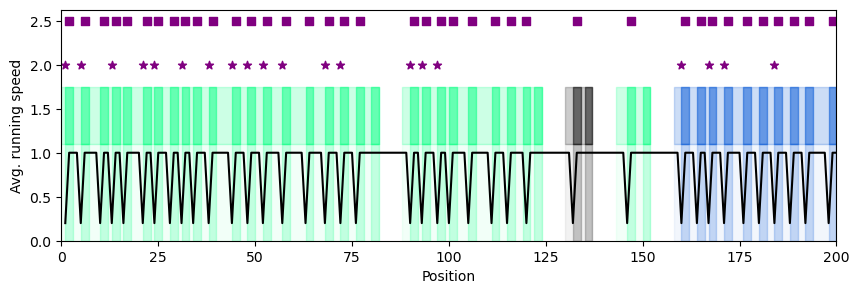

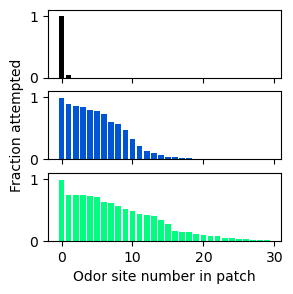

In [91]:
plot_sesson(
    '../../results/rl_agent_outputs/inf_patch_refactor_w_noise_2024-11-21_16_07_42_770943_var_noise_0.0001_activity_weight_10/state',
    env_idx=0,
    xlim=(0, 200),
    max_reward_param=30,
    max_reward_sites=30,
)

In [79]:
def plot_avg_stops_vs_reward_param(data_paths, update_num=None, max_reward_param=10, max_reward_sites=8, model_colors=None):

    cmap = mpl.colormaps['winter']
    if model_colors is None:
        model_colors = ['purple', 'green']

    scale = 1
    fig_sensitivity, axs_sensitivity = plt.subplots(4, 5, figsize=(8 * scale, 6 * scale), sharex=True, sharey=True)

    for idx_data_path, data_path in enumerate(data_paths):
    
        indices = [] if update_num is None else [update_num]
        state_data = load_compressed_data(
            data_path,
            indices=indices,
        )
    
        d = state_data.__next__()
    
        for env_idx in range(20):
            all_patch_bounds = []
            all_reward_site_bounds = []
            all_patch_nums = []
            all_actions = []
            all_positions = []
            all_rewards = []
            all_patch_reward_params = []
            all_current_reward_site_attempted = []
            all_obs = []
            
            for k in np.arange(len(d)):
                all_patch_bounds.append(d[k]['current_patch_bounds'][env_idx])
                all_reward_site_bounds.append(d[k]['reward_bounds'][env_idx])
                all_patch_nums.append(d[k]['current_patch_num'][env_idx])
                all_actions.append(d[k]['action'][env_idx])
                all_positions.append(d[k]['current_position'][env_idx])
                all_rewards.append(d[k]['reward'][env_idx])
                all_patch_reward_params.append(d[k]['patch_reward_param'][env_idx])
                all_current_reward_site_attempted.append(d[k]['current_reward_site_attempted'][env_idx])
                all_obs.append(d[k]['obs'][env_idx])
            
            all_dwell_times = []
            rewards_at_positions = [0]
            reward_attempted_at_positions = [False]
            dwell_time = 0
            last_p = None
            for i, p in enumerate(all_positions):
                if last_p is not None and (p != last_p):
                    all_dwell_times.append(dwell_time)
                    rewards_at_positions.append(0)
                    reward_attempted_at_positions.append(False)
                    dwell_time = 0
                if last_p is not None:
                    dwell_time += 1
                rewards_at_positions[-1] += all_rewards[i]
                reward_attempted_at_positions[-1] = True if all_current_reward_site_attempted[i] else reward_attempted_at_positions[-1]
                last_p = p
            
            rewards_at_positions = np.array(rewards_at_positions)
            reward_attempted_at_positions = np.array(reward_attempted_at_positions)
            
            reward_param_of_stop = []
            site_idx_of_stop =  []
            site_stops_for_patch_type = np.zeros((np.array(all_patch_nums).max() + 1, max_reward_sites))
            patches_entered_for_patch_type = np.zeros((np.array(all_patch_nums).max() + 1,))
            reward_param_for_patch_type = np.zeros((np.array(all_patch_nums).max() + 1,))
            
            last_pb = None
            patch_count = 0
            for i, pb in enumerate(all_patch_bounds):
                if last_pb is None or (pb != last_pb).any():
                    patches_entered_for_patch_type[all_patch_nums[i]] += 1
                    reward_param_for_patch_type[all_patch_nums[i]] = all_patch_reward_params[i]
                    patch_count += 1
                    pb_amended = pb.copy()
                    for k_rwsb, rwsb in enumerate(all_reward_site_bounds[i]):
                        if np.sum(reward_attempted_at_positions[int(rwsb[0]):int(rwsb[1])]) == 0:
                            pb_amended[1] = rwsb[1]
                            break
                        else:
                            reward_param_of_stop.append(all_patch_reward_params[i])
                            site_idx_of_stop.append(k_rwsb)
                            if k_rwsb < site_stops_for_patch_type.shape[1]:
                                site_stops_for_patch_type[all_patch_nums[i], k_rwsb] += 1
                last_pb = pb
    
            print(reward_param_for_patch_type)
    
            
            scale = 1
            fig, axs = plt.subplots(3, 1, figsize=(3 * scale, 3 * scale), sharex=True, sharey=True)
            # mx = site_stops_for_patch_type.max()
    
            avg_stops_for_patch_type = np.empty((site_stops_for_patch_type.shape[0],))
            
            x = np.arange(1, site_stops_for_patch_type.shape[1] + 1)
            for k in range(site_stops_for_patch_type.shape[0]):
                cdf = site_stops_for_patch_type[k, :] / patches_entered_for_patch_type[k]
                c = cmap(reward_param_for_patch_type[k] / max_reward_param) if reward_param_for_patch_type[k] > 0 else 'black'
                axs[k].bar(x, cdf, color=c)
                axs[k].set_ylim(0, 1.1)
    
                pdf = cdf - np.concatenate([cdf[1:], np.zeros(1)])
                # axs[k].bar(x, pdf, color=cmap(reward_param_for_patch_type[k] / max_reward_param))
    
                avg_stops_for_patch_type[k] = np.dot(pdf, x)
    
            axs[1].set_ylabel('Fraction attempted')
            axs[2].set_xlabel('Odor site number in patch')
    
            ordering = np.argsort(reward_param_for_patch_type)
    
            axs_sensitivity[int(env_idx / 5), env_idx % 5].plot(reward_param_for_patch_type[ordering], avg_stops_for_patch_type[ordering], c=model_colors[idx_data_path])
            axs_sensitivity[int(env_idx / 5), env_idx % 5].scatter(reward_param_for_patch_type, avg_stops_for_patch_type, c=model_colors[idx_data_path])
        
    axs_sensitivity[0, 0].set_ylim(0)
    axs_sensitivity[0, 0].set_xlim(0, max_reward_param * 1.1)
    axs_sensitivity[1, 0].set_ylabel('Avg number of stops')
    axs_sensitivity[-1, 2].set_xlabel('Reward decay parameter')
            
    

FileNotFoundError: [WinError 3] The system cannot find the path specified: '../data/rl_agent_outputs/det_reward_to_stoch_long_trials_max_reward_decay_30_2024-08-29_17_06_50_928811/state'

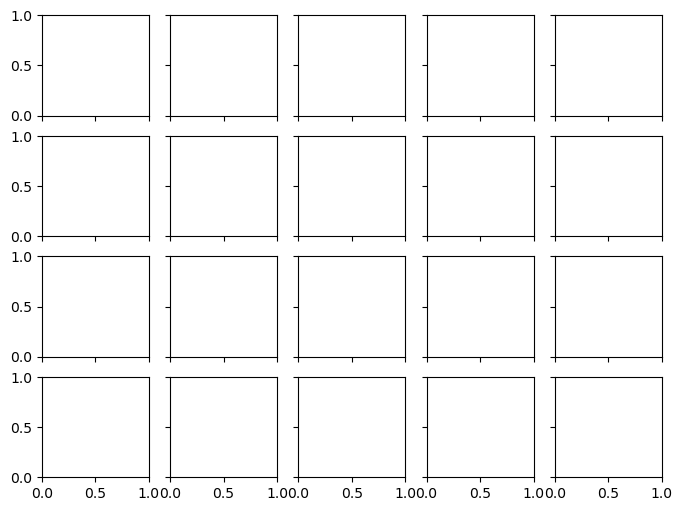

In [18]:
plot_avg_stops_vs_reward_param([
        '../data/rl_agent_outputs/det_reward_to_stoch_long_trials_max_reward_decay_30_2024-08-29_17_06_50_928811/state',
    ],
    max_reward_param=30,
)

['00000.pkl', '00001.pkl', '00002.pkl', '00003.pkl', '00004.pkl', '00005.pkl', '00006.pkl', '00007.pkl', '00008.pkl', '00009.pkl', '00010.pkl', '00011.pkl', '00012.pkl', '00013.pkl', '00014.pkl', '00015.pkl', '00016.pkl', '00017.pkl', '00018.pkl', '00019.pkl', '00020.pkl', '00021.pkl', '00022.pkl', '00023.pkl', '00024.pkl', '00025.pkl', '00026.pkl', '00027.pkl', '00028.pkl', '00029.pkl', '00030.pkl', '00031.pkl', '00032.pkl', '00033.pkl', '00034.pkl', '00035.pkl', '00036.pkl', '00037.pkl', '00038.pkl', '00039.pkl', '00040.pkl', '00041.pkl', '00042.pkl', '00043.pkl', '00044.pkl', '00045.pkl', '00046.pkl', '00047.pkl', '00048.pkl', '00049.pkl', '00050.pkl', '00051.pkl', '00052.pkl', '00053.pkl', '00054.pkl', '00055.pkl', '00056.pkl', '00057.pkl', '00058.pkl', '00059.pkl', '00060.pkl', '00061.pkl', '00062.pkl', '00063.pkl', '00064.pkl', '00065.pkl', '00066.pkl', '00067.pkl', '00068.pkl', '00069.pkl', '00070.pkl', '00071.pkl', '00072.pkl', '00073.pkl', '00074.pkl', '00075.pkl', '00076.pkl'

C:\Users\david.bell\AppData\Local\Temp\ipykernel_48936\4096302550.py:86: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(3, 1, figsize=(3 * scale, 3 * scale), sharex=True, sharey=True)


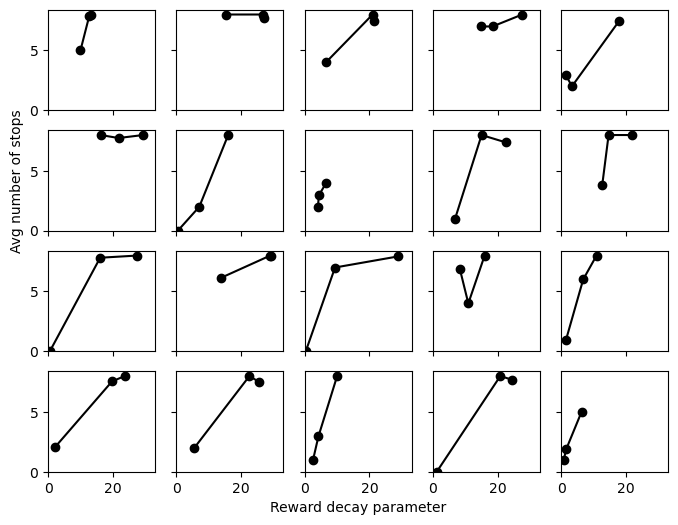

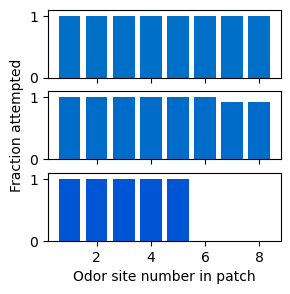

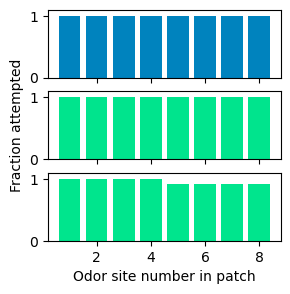

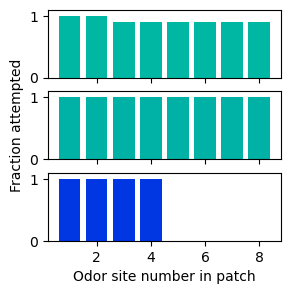

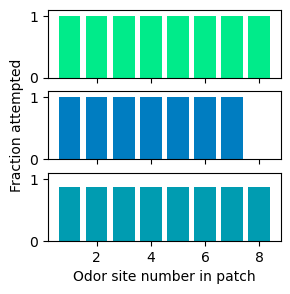

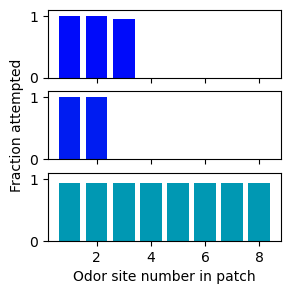

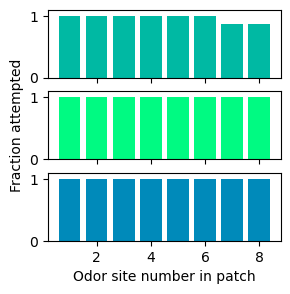

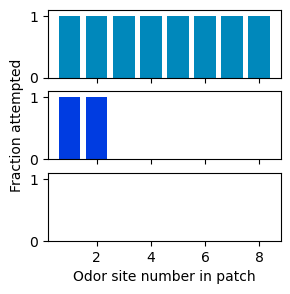

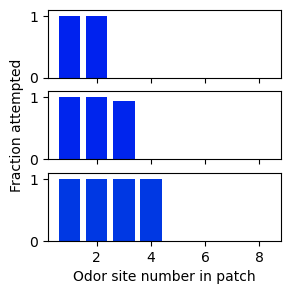

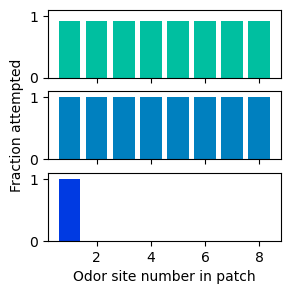

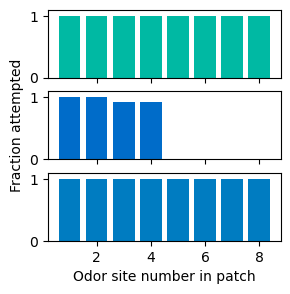

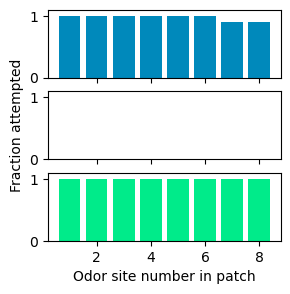

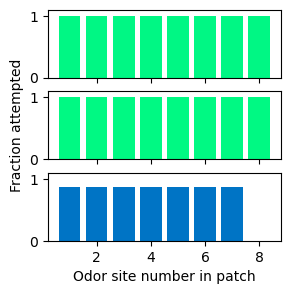

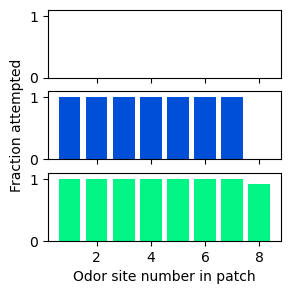

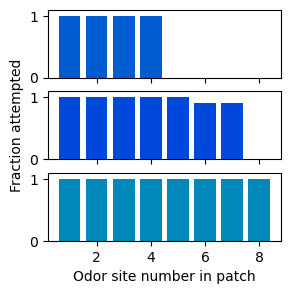

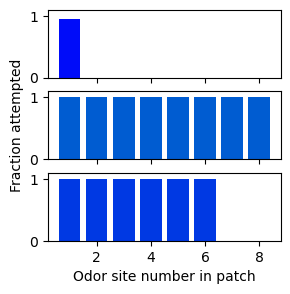

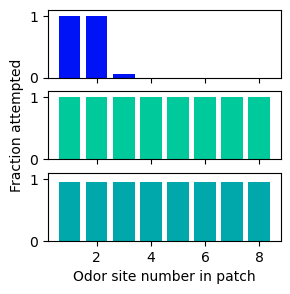

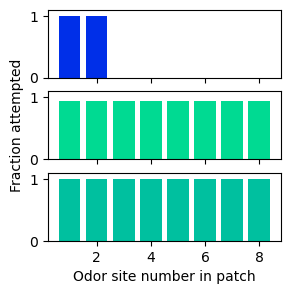

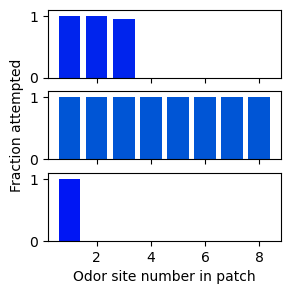

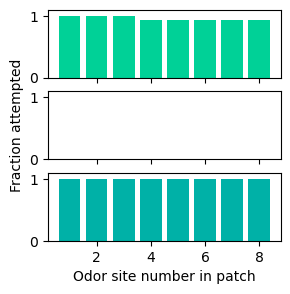

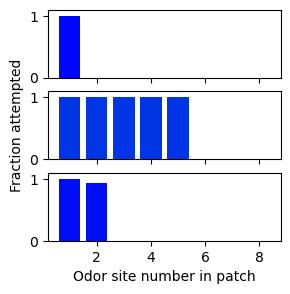

In [79]:
plot_avg_stops_vs_reward_param(
    '../data/grid_search_agent_outputs/expect_reward_to_stoch_long_trials_max_reward_decay_30_2024-08-30_12_32_24_721439/state',
    max_reward_param=30,
)

['00000.pkl', '00001.pkl', '00002.pkl', '00003.pkl', '00004.pkl', '00005.pkl', '00006.pkl', '00007.pkl', '00008.pkl', '00009.pkl', '00010.pkl', '00011.pkl', '00012.pkl', '00013.pkl', '00014.pkl', '00015.pkl', '00016.pkl', '00017.pkl', '00018.pkl', '00019.pkl', '00020.pkl', '00021.pkl', '00022.pkl', '00023.pkl', '00024.pkl', '00025.pkl', '00026.pkl', '00027.pkl', '00028.pkl', '00029.pkl', '00030.pkl', '00031.pkl', '00032.pkl', '00033.pkl', '00034.pkl', '00035.pkl', '00036.pkl', '00037.pkl', '00038.pkl', '00039.pkl', '00040.pkl', '00041.pkl', '00042.pkl', '00043.pkl', '00044.pkl', '00045.pkl', '00046.pkl', '00047.pkl', '00048.pkl', '00049.pkl', '00050.pkl', '00051.pkl', '00052.pkl', '00053.pkl', '00054.pkl', '00055.pkl', '00056.pkl', '00057.pkl', '00058.pkl', '00059.pkl', '00060.pkl', '00061.pkl', '00062.pkl', '00063.pkl', '00064.pkl', '00065.pkl', '00066.pkl', '00067.pkl', '00068.pkl', '00069.pkl', '00070.pkl', '00071.pkl', '00072.pkl', '00073.pkl', '00074.pkl', '00075.pkl', '00076.pkl'

C:\Users\david.bell\AppData\Local\Temp\ipykernel_48936\3331532394.py:89: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(3, 1, figsize=(3 * scale, 3 * scale), sharex=True, sharey=True)


[13.11613954 12.66899728  9.97701115]
[15.3737454  26.79911393 26.89916336]
[21.47299821 20.96209186  6.56107592]
[27.56646615 14.70349454 18.3911415 ]
[ 1.34672911  3.31893473 17.89205672]
[21.73160882 29.34188641 16.20102653]
[15.97258518  7.05857701  0.44082425]
[4.10150292 4.34912146 6.6349044 ]
[22.48923609 15.00535967  6.8214197 ]
[21.77552448 12.66408778 14.61427024]
[16.05880786  0.53579138 27.57053554]
[28.97590102 29.18077331 13.6581325 ]
[ 0.34060376  9.36110417 28.73235181]
[10.90999954  8.33448777 15.94700672]
[ 1.46349831 10.88579218  6.77012016]
[ 2.13022071 23.63086525 19.7243723 ]
[ 5.53702274 25.58176875 22.52907495]
[ 4.23013746 10.01025224  2.58168699]
[24.49354057  1.17309861 20.78355169]
[0.74632587 6.25709068 1.61812038]


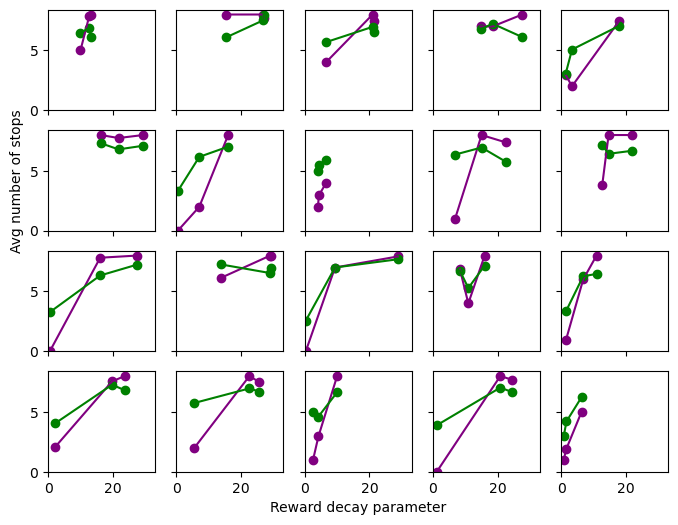

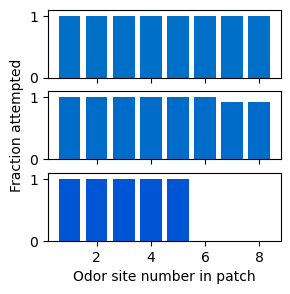

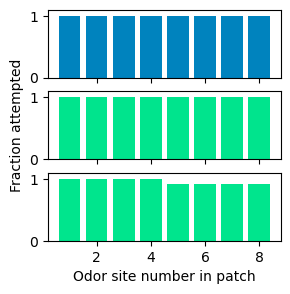

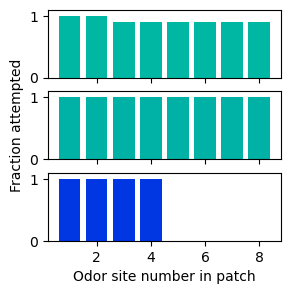

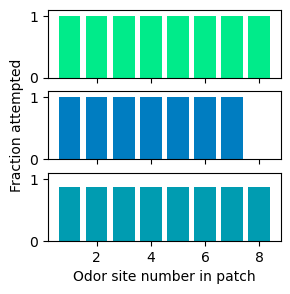

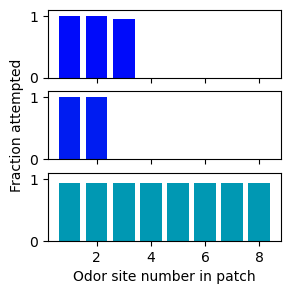

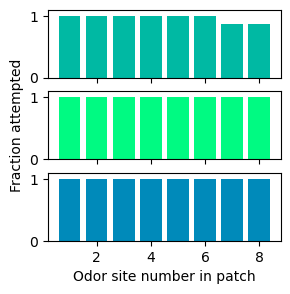

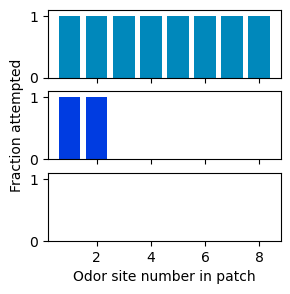

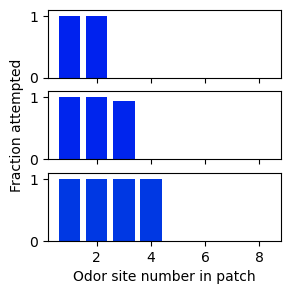

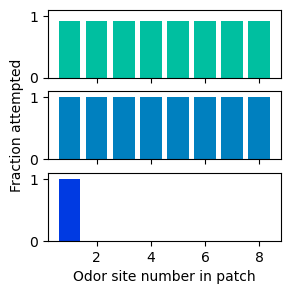

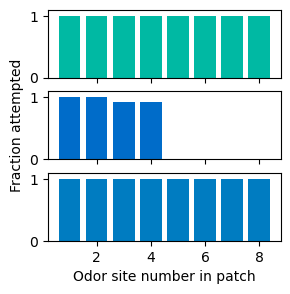

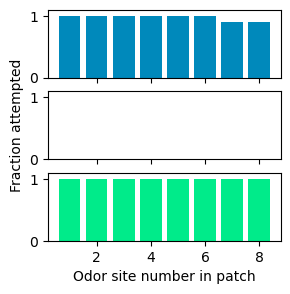

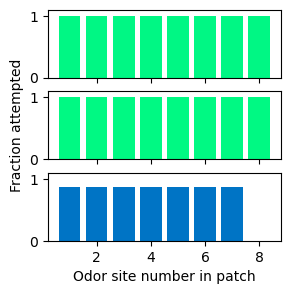

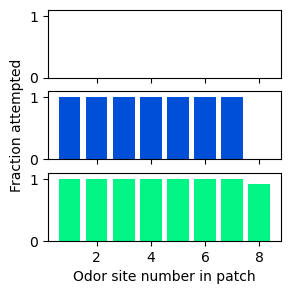

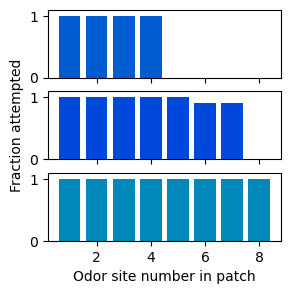

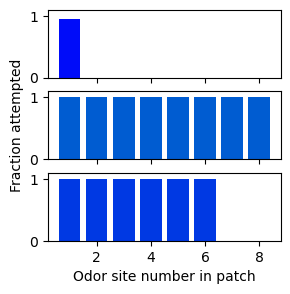

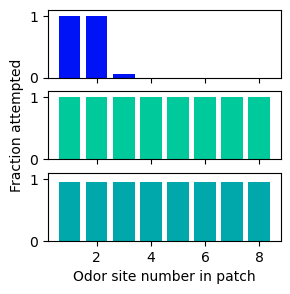

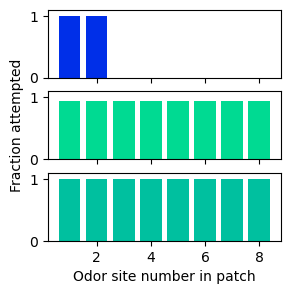

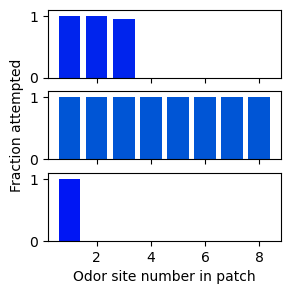

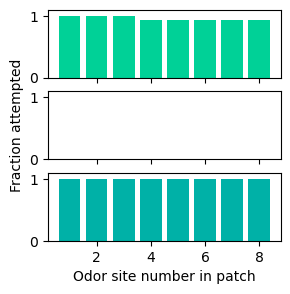

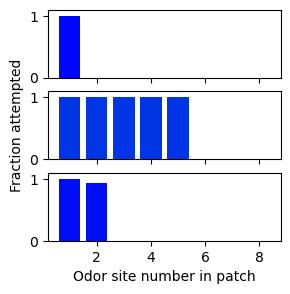

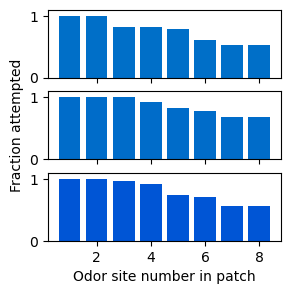

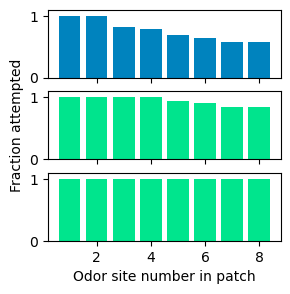

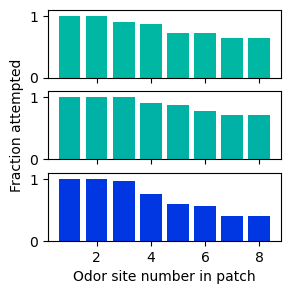

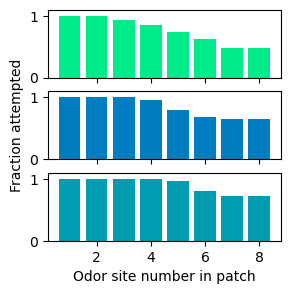

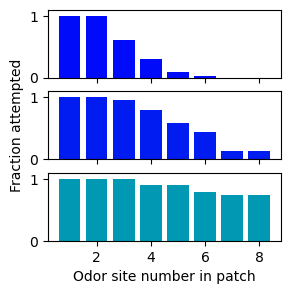

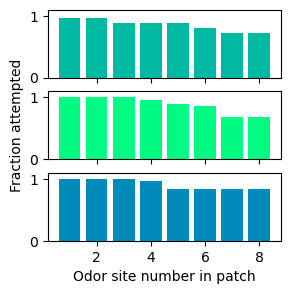

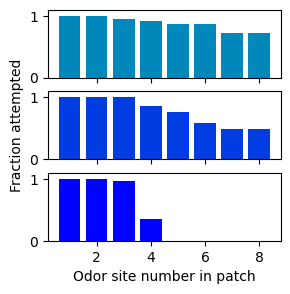

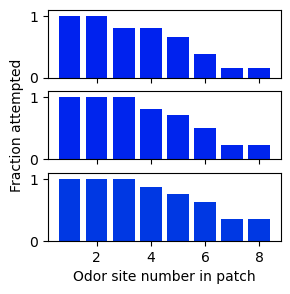

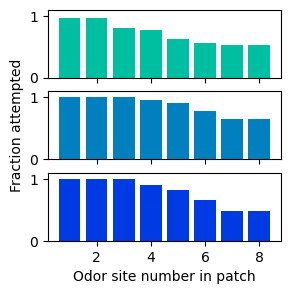

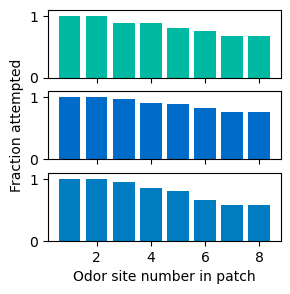

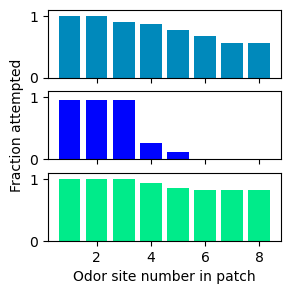

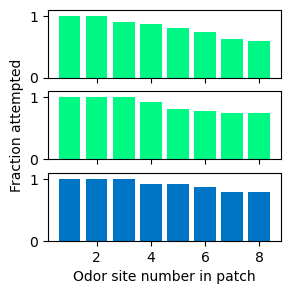

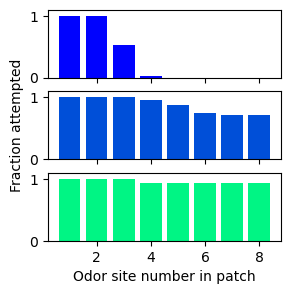

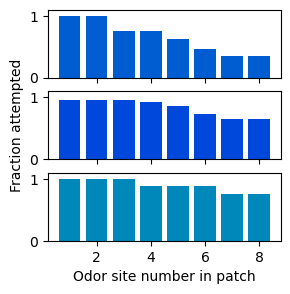

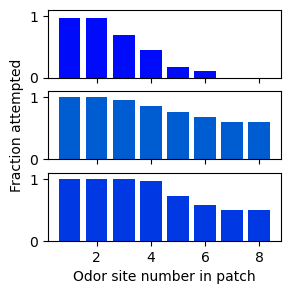

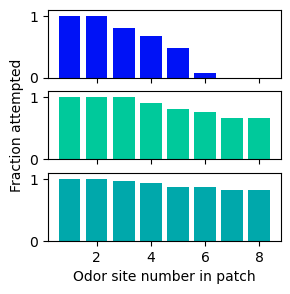

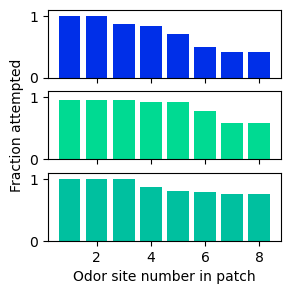

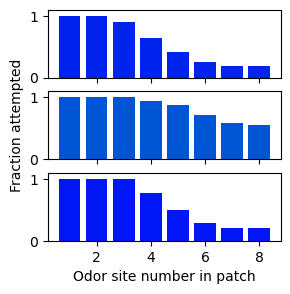

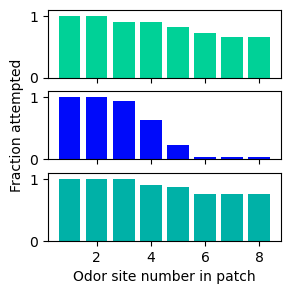

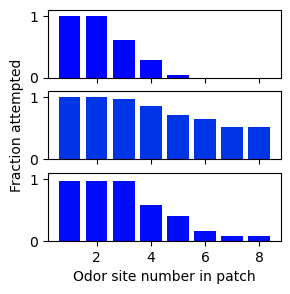

In [81]:
plot_avg_stops_vs_reward_param([
        '../data/grid_search_agent_outputs/expect_reward_to_stoch_long_trials_max_reward_decay_30_2024-08-30_12_32_24_721439/state',
        '../data/rl_agent_outputs/det_reward_to_stoch_long_trials_max_reward_decay_30_2024-08-29_17_06_50_928811/state',
    ],
    max_reward_param=30,
)

['00000.pkl', '00001.pkl', '00002.pkl', '00003.pkl', '00004.pkl', '00005.pkl', '00006.pkl', '00007.pkl']
[29.48662426 23.66095478  0.71447973]
[29.19807054  0.47113962 14.7244753 ]
[18.19635425 27.54291542  7.47346867]
[26.84907169 28.56229832 18.25567959]
[ 9.40378795 18.31319346 29.31358886]
[29.87627645 27.1345541   3.95157162]
[19.74759599 28.67383103 11.98380772]
[13.63203201 27.49286419 13.76307339]
[ 4.64075641 27.99233014  1.36394052]
[19.7896971   8.49636436  3.36747947]
[ 0.45198345  2.01922589 12.87670778]
[22.90474573  5.67957509 23.01040669]
[18.27383099 26.5147168   3.93217838]
[14.95296686 26.69051781  3.39406465]
[ 7.01845244 22.47351071  2.81499773]
[24.14437109  3.04286757  7.82871774]
[11.10371169 13.1844066  19.57095923]
[29.81043853 11.27660666 27.99675261]
[27.00368805  9.37225607 27.84977016]
[16.32271518 14.42917797  2.25132288]


C:\Users\david.bell\AppData\Local\Temp\ipykernel_84452\1050608942.py:90: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(3, 1, figsize=(3 * scale, 3 * scale), sharex=True, sharey=True)


['00000.pkl', '00001.pkl', '00002.pkl', '00003.pkl', '00004.pkl', '00005.pkl', '00006.pkl', '00007.pkl']
[12.30079779  8.23013969 14.56937717]
[ 1.8682313  14.28654768 23.20190322]
[16.17289546 20.84648357 29.07972594]
[26.48680121  9.26512888  7.83812929]
[ 8.93289045 13.53984482 12.85891912]
[ 2.58117664 29.29894967  7.1223064 ]
[24.09375592 16.00858907  3.4250653 ]
[ 4.85010554  6.99989656 27.11210111]
[ 0.68291748  2.45629678 11.47344918]
[ 7.28901795 13.84053324  4.4088918 ]
[22.53932196  7.31790163 19.10780329]
[14.13798178 16.92931907  7.82546878]
[19.42246712 17.72408819 17.91051707]
[ 3.38038574 19.61938126 17.10787751]
[25.95153103  2.39891625 25.69788944]
[20.15582118 27.96907144 25.15805243]
[23.88754307 28.13178591 28.11767086]
[21.7979668  29.21116651  3.37356332]
[ 0.30109883  7.67281976 19.34935991]
[14.86372075 19.23533491  4.10244008]


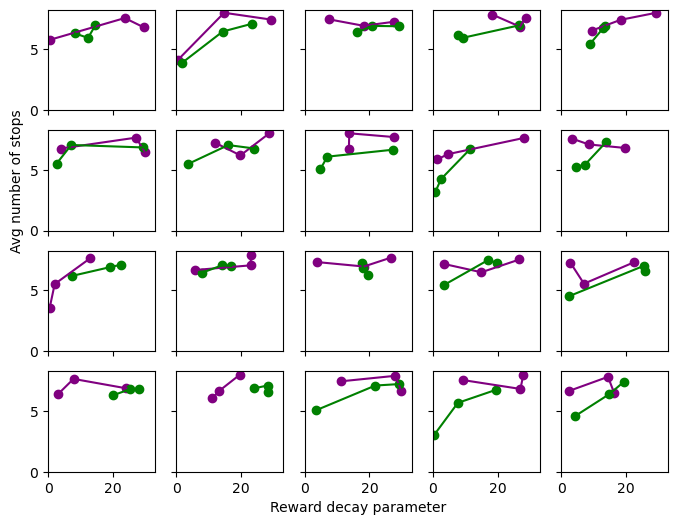

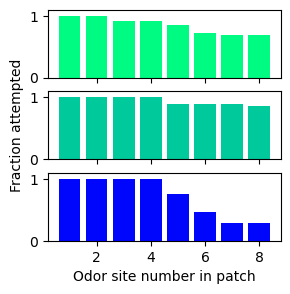

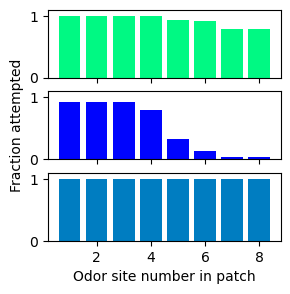

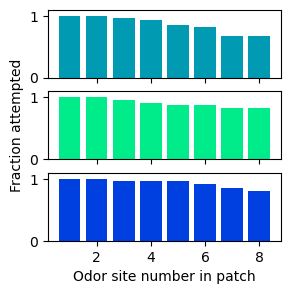

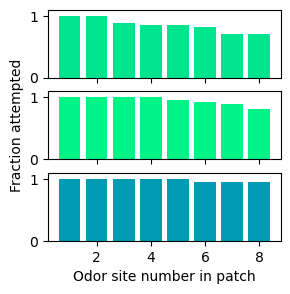

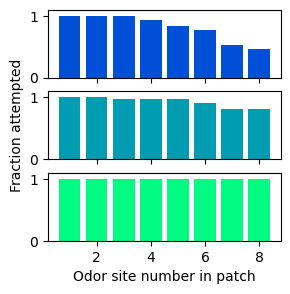

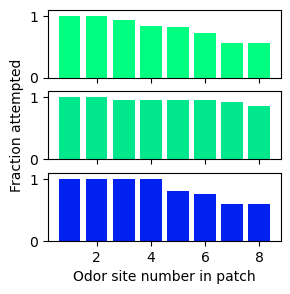

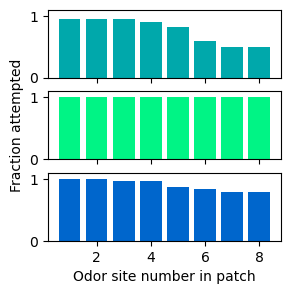

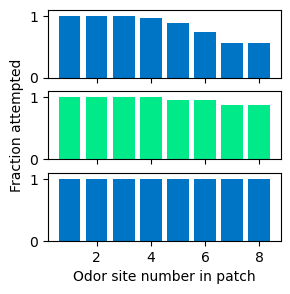

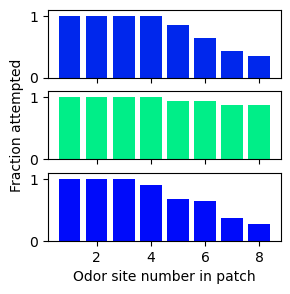

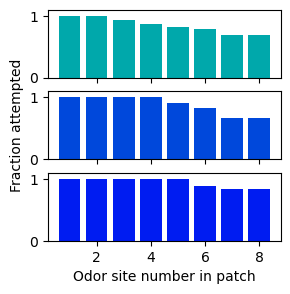

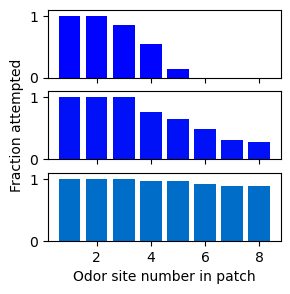

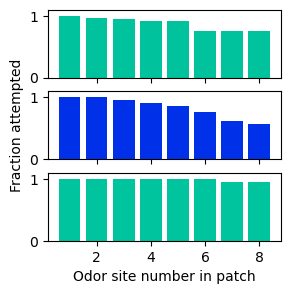

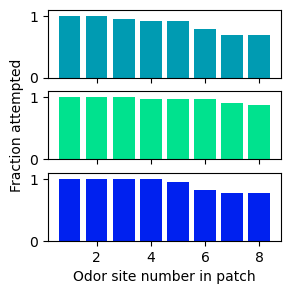

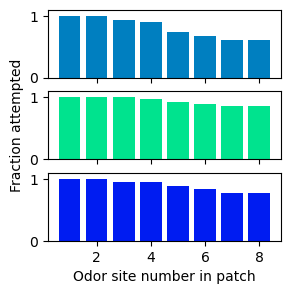

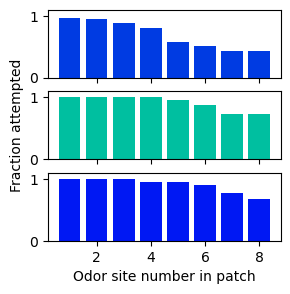

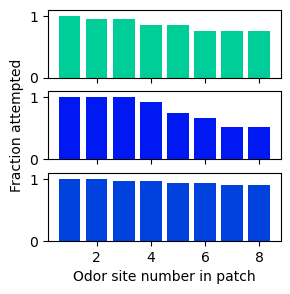

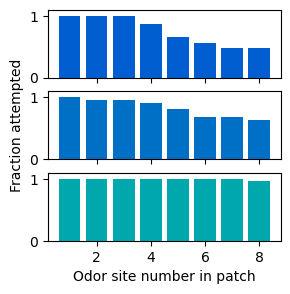

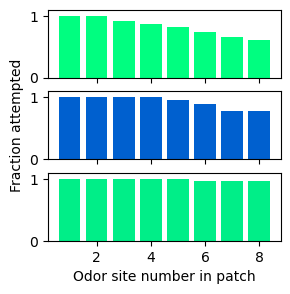

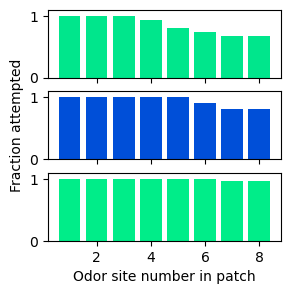

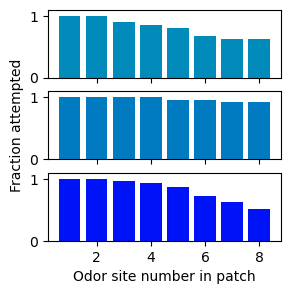

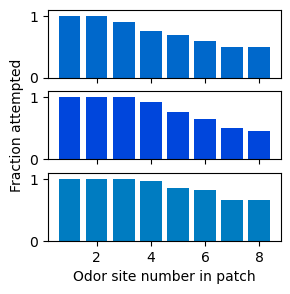

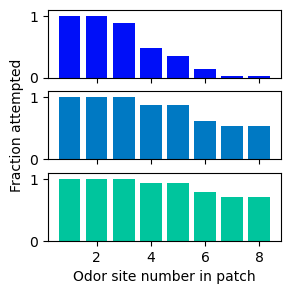

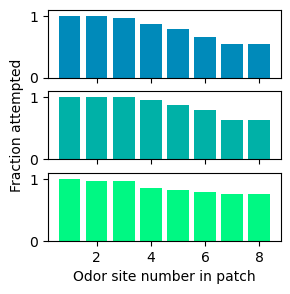

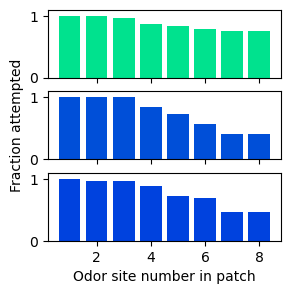

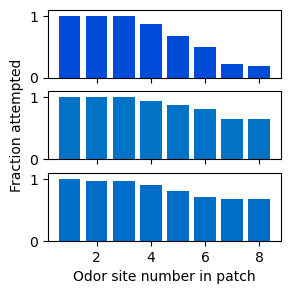

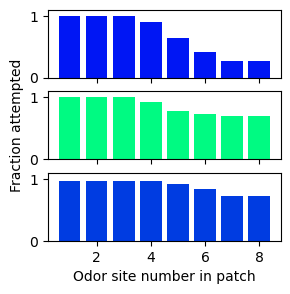

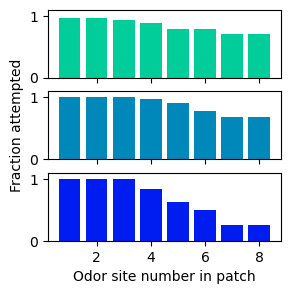

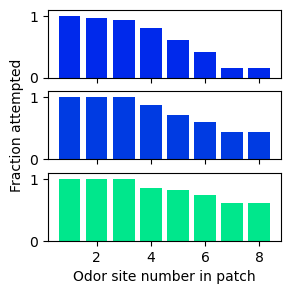

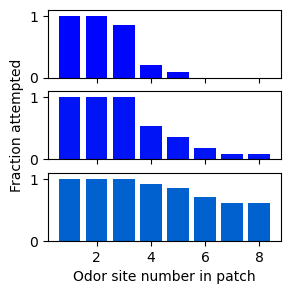

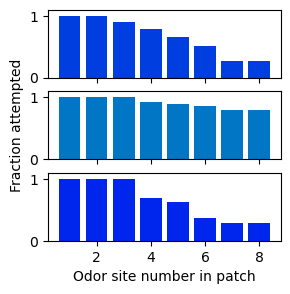

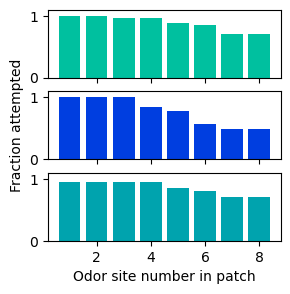

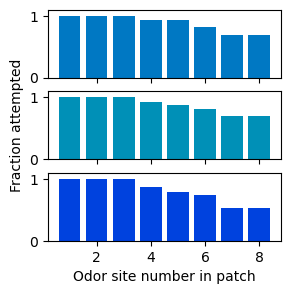

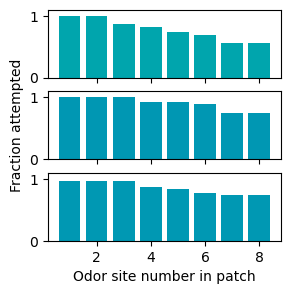

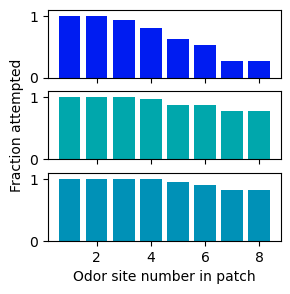

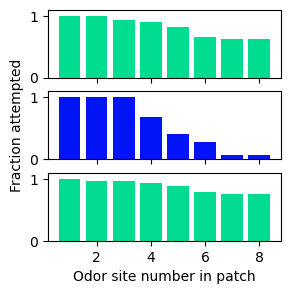

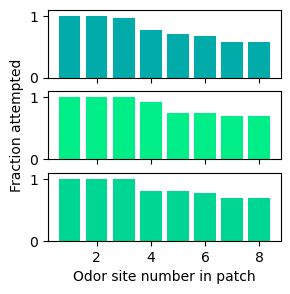

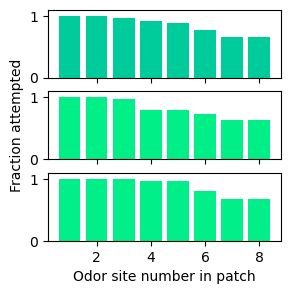

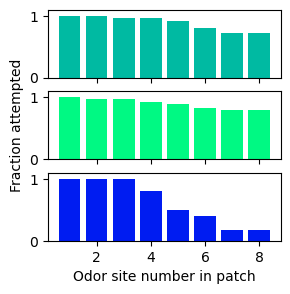

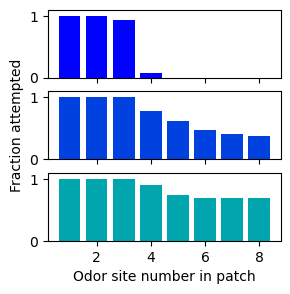

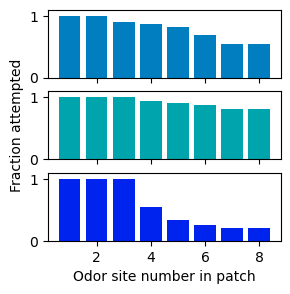

In [34]:
plot_avg_stops_vs_reward_param([
        '../data/rl_agent_outputs/test_run_all_same_seed_2024-10-02_17_53_58_116272/state',
        '../data/rl_agent_outputs/test_run_all_same_seed_2024-10-03_07_57_15_997601/state',
    ],
    max_reward_param=30,
)

['00000.pkl', '00001.pkl', '00002.pkl', '00003.pkl', '00004.pkl', '00005.pkl', '00006.pkl', '00007.pkl', '00008.pkl', '00009.pkl', '00010.pkl', '00011.pkl', '00012.pkl', '00013.pkl', '00014.pkl', '00015.pkl', '00016.pkl', '00017.pkl', '00018.pkl', '00019.pkl', '00020.pkl', '00021.pkl', '00022.pkl', '00023.pkl', '00024.pkl', '00025.pkl', '00026.pkl', '00027.pkl', '00028.pkl', '00029.pkl', '00030.pkl', '00031.pkl', '00032.pkl', '00033.pkl', '00034.pkl', '00035.pkl', '00036.pkl', '00037.pkl', '00038.pkl', '00039.pkl', '00040.pkl', '00041.pkl', '00042.pkl', '00043.pkl', '00044.pkl', '00045.pkl', '00046.pkl', '00047.pkl', '00048.pkl', '00049.pkl', '00050.pkl', '00051.pkl', '00052.pkl', '00053.pkl', '00054.pkl', '00055.pkl', '00056.pkl', '00057.pkl', '00058.pkl', '00059.pkl', '00060.pkl', '00061.pkl', '00062.pkl', '00063.pkl', '00064.pkl', '00065.pkl', '00066.pkl', '00067.pkl', '00068.pkl', '00069.pkl', '00070.pkl', '00071.pkl', '00072.pkl', '00073.pkl', '00074.pkl', '00075.pkl', '00076.pkl'

C:\Users\david.bell\AppData\Local\Temp\ipykernel_84452\925876596.py:90: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(3, 1, figsize=(3 * scale, 3 * scale), sharex=True, sharey=True)


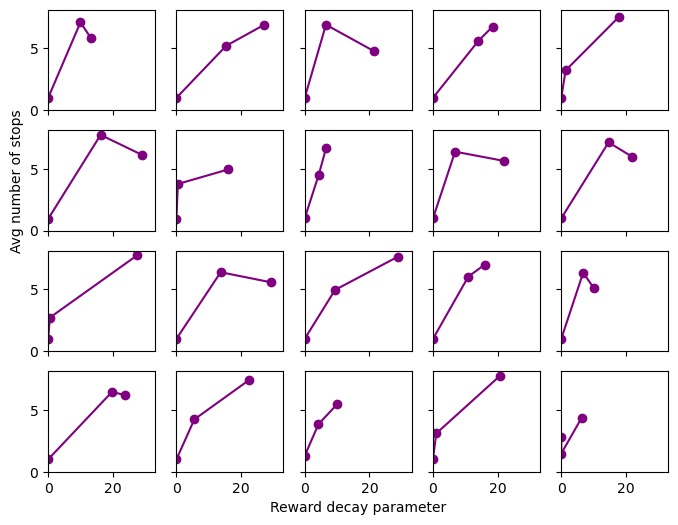

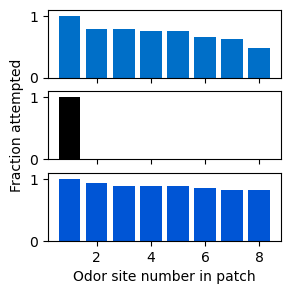

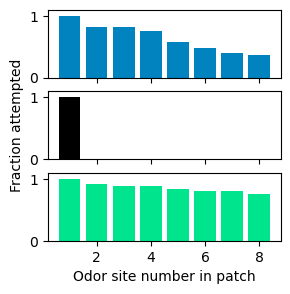

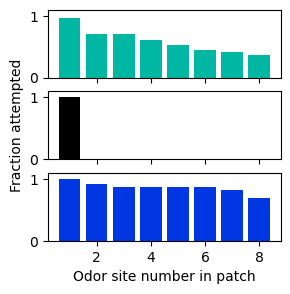

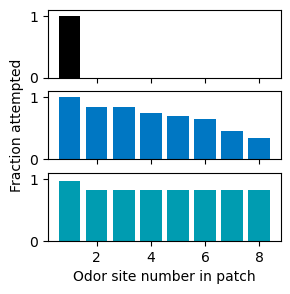

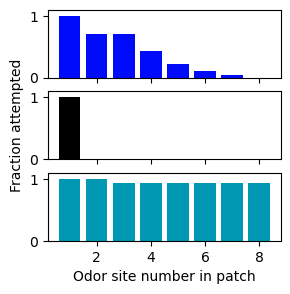

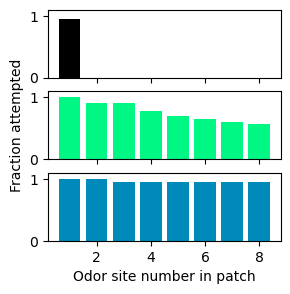

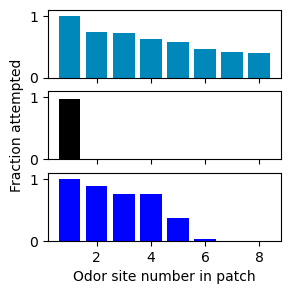

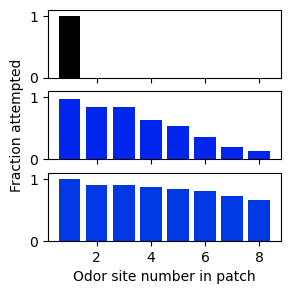

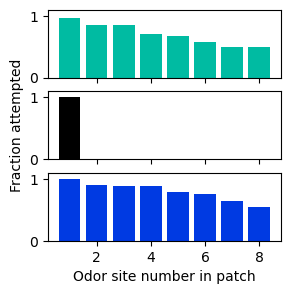

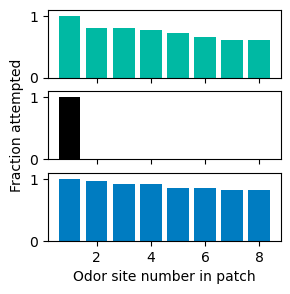

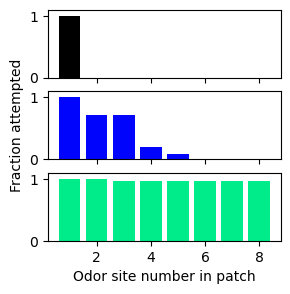

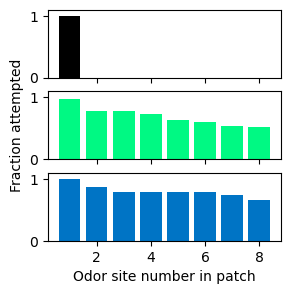

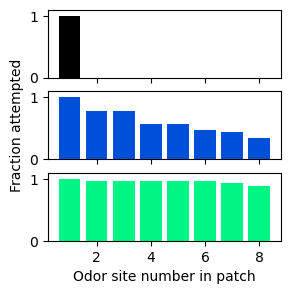

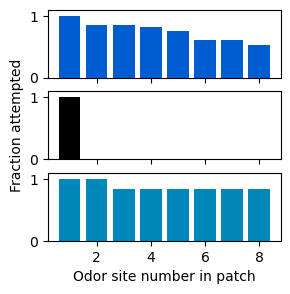

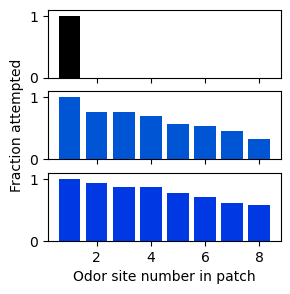

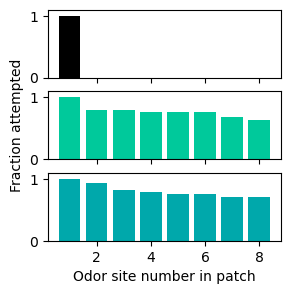

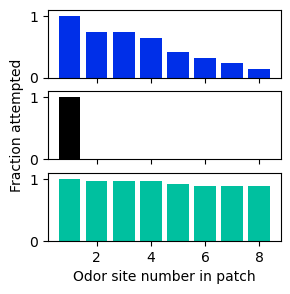

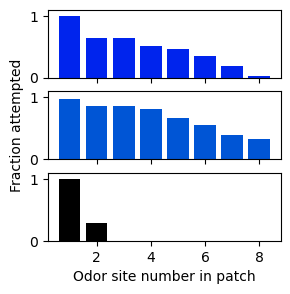

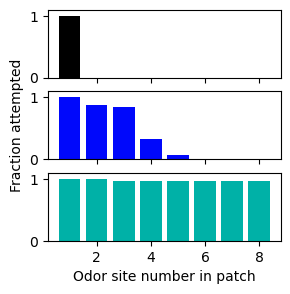

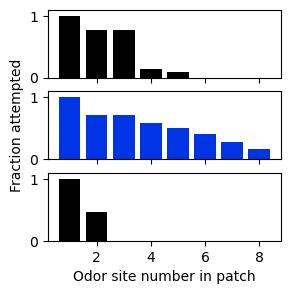

In [42]:
plot_avg_stops_vs_reward_param([
        '../data/rl_agent_outputs/one_patch_no_reward_2024-10-03_13_44_01_290911_var_noise_0_activity_weight_0/state',
    ],
    max_reward_param=30,
)

['00000.pkl', '00001.pkl', '00002.pkl', '00003.pkl', '00004.pkl', '00005.pkl', '00006.pkl', '00007.pkl', '00008.pkl', '00009.pkl', '00010.pkl', '00011.pkl', '00012.pkl', '00013.pkl', '00014.pkl', '00015.pkl', '00016.pkl', '00017.pkl', '00018.pkl', '00019.pkl', '00020.pkl', '00021.pkl', '00022.pkl', '00023.pkl', '00024.pkl', '00025.pkl', '00026.pkl', '00027.pkl', '00028.pkl', '00029.pkl', '00030.pkl', '00031.pkl', '00032.pkl', '00033.pkl', '00034.pkl', '00035.pkl', '00036.pkl', '00037.pkl', '00038.pkl', '00039.pkl', '00040.pkl', '00041.pkl', '00042.pkl', '00043.pkl', '00044.pkl', '00045.pkl', '00046.pkl', '00047.pkl', '00048.pkl', '00049.pkl', '00050.pkl', '00051.pkl', '00052.pkl', '00053.pkl', '00054.pkl', '00055.pkl', '00056.pkl', '00057.pkl', '00058.pkl', '00059.pkl', '00060.pkl', '00061.pkl', '00062.pkl', '00063.pkl', '00064.pkl', '00065.pkl', '00066.pkl', '00067.pkl', '00068.pkl', '00069.pkl', '00070.pkl', '00071.pkl', '00072.pkl', '00073.pkl', '00074.pkl', '00075.pkl', '00076.pkl'

C:\Users\david.bell\AppData\Local\Temp\ipykernel_19960\3605793695.py:91: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(3, 1, figsize=(3 * scale, 3 * scale), sharex=True, sharey=True)


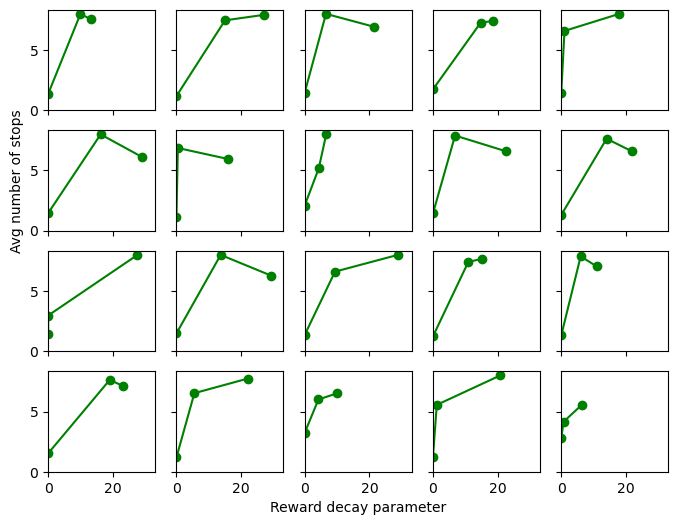

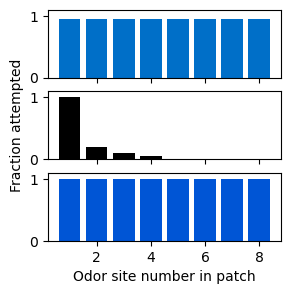

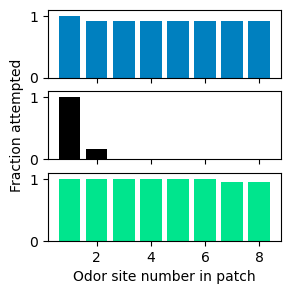

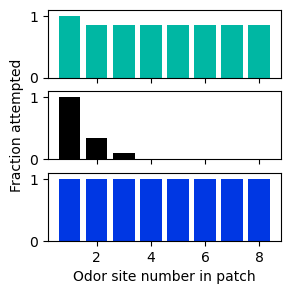

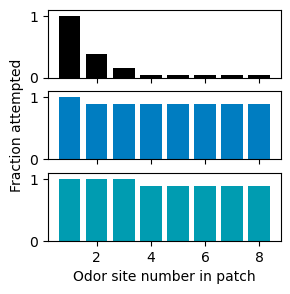

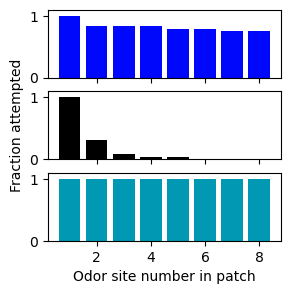

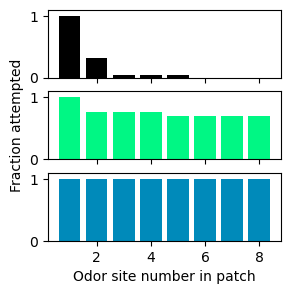

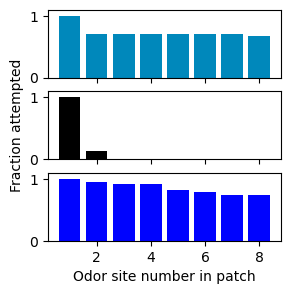

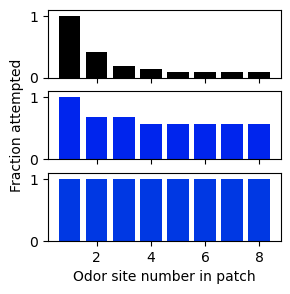

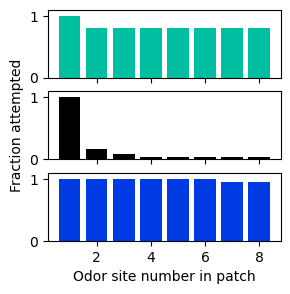

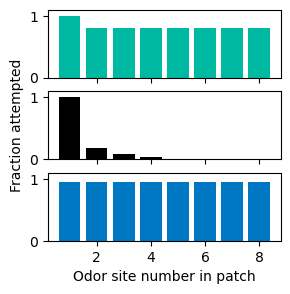

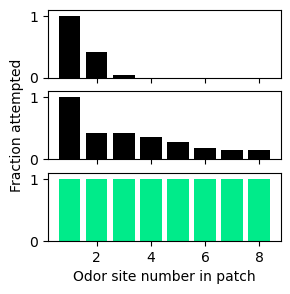

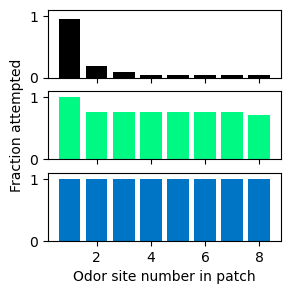

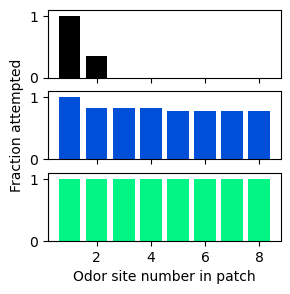

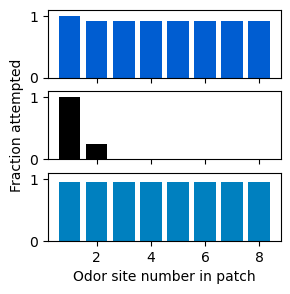

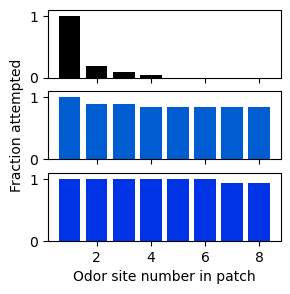

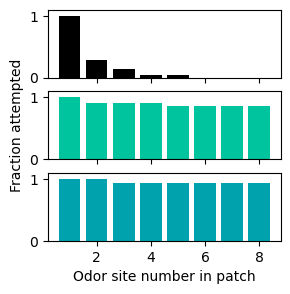

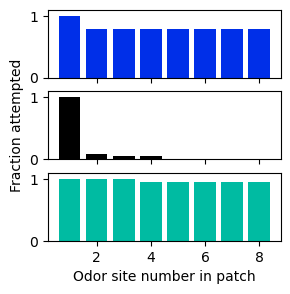

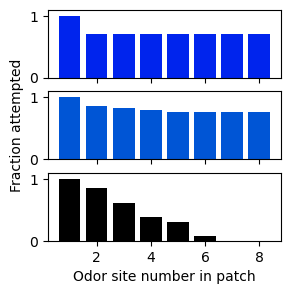

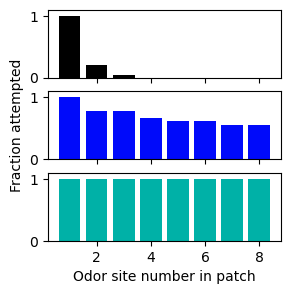

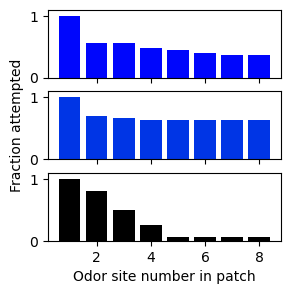

In [23]:
plot_avg_stops_vs_reward_param([
        '../data/rl_agent_outputs/shifting_reward_probs_2024-10-10_00_25_42_982912_var_noise_0_activity_weight_0/state',
    ],
    max_reward_param=30,
    model_colors=['green'],
)

['00000.pkl', '00001.pkl', '00002.pkl', '00003.pkl', '00004.pkl', '00005.pkl', '00006.pkl', '00007.pkl']
[ 0.44291064 12.07375831 24.18607214]
[14.55773848 12.06353917 14.44202905]
[ 0.66587119 15.07820205  4.92783689]
[25.9577384  26.6627671  29.51592324]
[23.69892531 13.49189858  9.17703678]
[ 2.38563282 17.91656831 26.05994245]
[17.1046785   3.63157459  4.25495591]
[ 2.19620955 19.53704258 16.71338542]
[ 1.10875363 29.09448642 12.86858439]
[19.01802021 20.96190877 12.87081623]
[27.25417901 25.5341727   6.14454584]
[10.57969297  8.16703532 23.66914373]
[ 2.19972062 25.05776368 29.97537109]
[26.47644586 27.19280138  7.2844144 ]
[19.73966826  7.5804255  14.67345018]
[ 1.21552448  8.7552642  12.72407513]
[19.08407253 23.51699504 11.18312484]
[17.14449877 15.42653644 26.2246503 ]
[21.76158879  5.11220296  9.49280678]
[16.92201708 27.63651379  4.84447719]


C:\Users\david.bell\AppData\Local\Temp\ipykernel_19960\3605793695.py:91: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(3, 1, figsize=(3 * scale, 3 * scale), sharex=True, sharey=True)


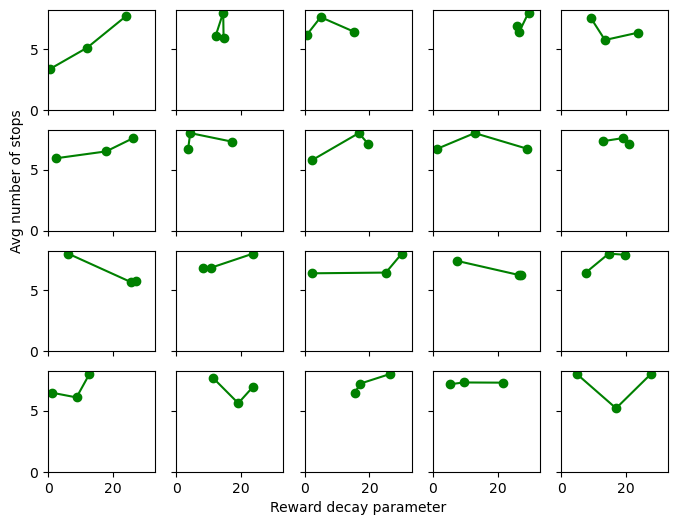

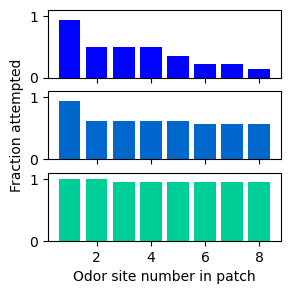

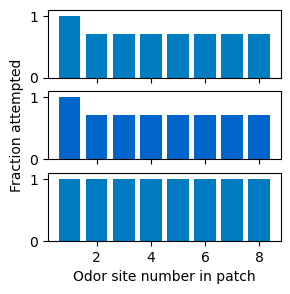

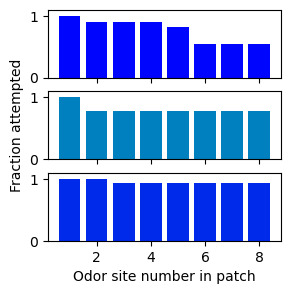

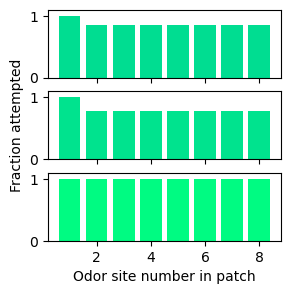

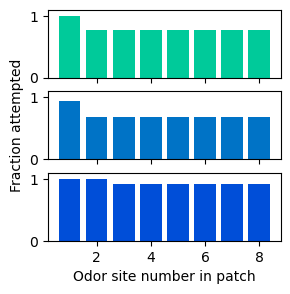

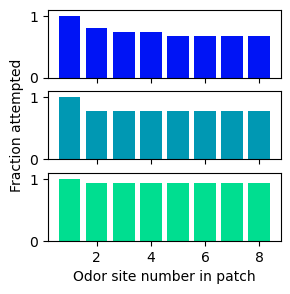

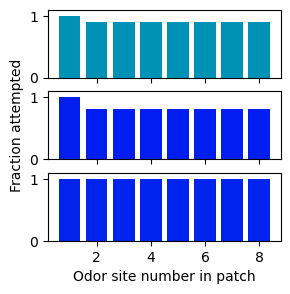

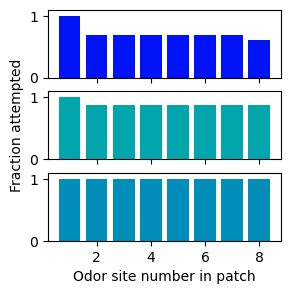

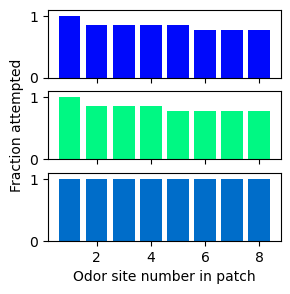

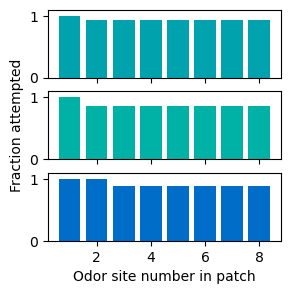

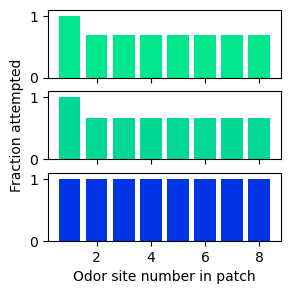

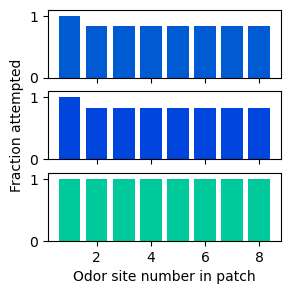

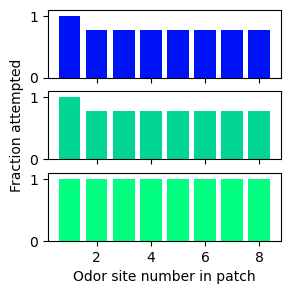

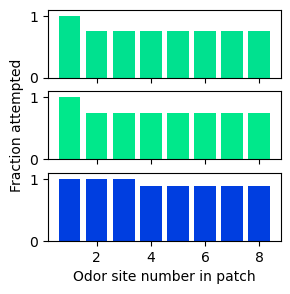

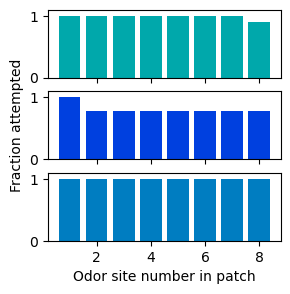

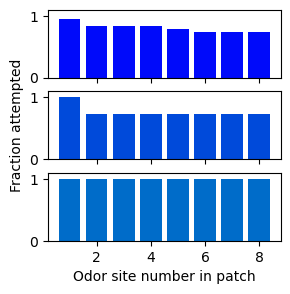

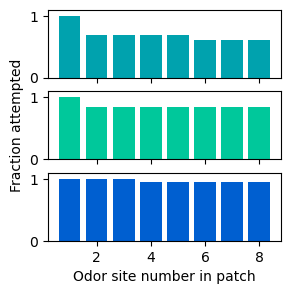

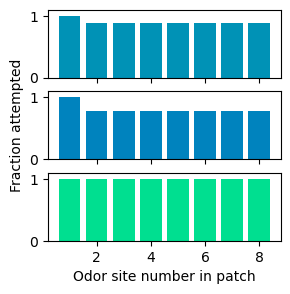

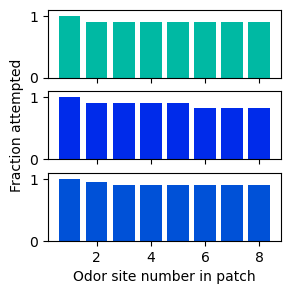

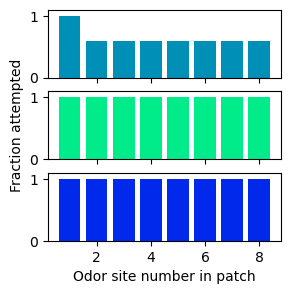

In [22]:
plot_avg_stops_vs_reward_param([
        '../data/rl_agent_outputs/test_shifting_reward_curves_2024-10-10_09_56_14_534732/state',
    ],
    max_reward_param=30,
    model_colors=['green'],
)

['00000.pkl', '00001.pkl', '00002.pkl', '00003.pkl', '00004.pkl', '00005.pkl', '00006.pkl', '00007.pkl', '00008.pkl', '00009.pkl', '00010.pkl', '00011.pkl', '00012.pkl', '00013.pkl', '00014.pkl', '00015.pkl', '00016.pkl', '00017.pkl', '00018.pkl', '00019.pkl', '00020.pkl', '00021.pkl', '00022.pkl', '00023.pkl', '00024.pkl', '00025.pkl', '00026.pkl', '00027.pkl', '00028.pkl', '00029.pkl', '00030.pkl', '00031.pkl', '00032.pkl', '00033.pkl', '00034.pkl', '00035.pkl', '00036.pkl', '00037.pkl', '00038.pkl', '00039.pkl', '00040.pkl', '00041.pkl', '00042.pkl', '00043.pkl', '00044.pkl', '00045.pkl', '00046.pkl', '00047.pkl', '00048.pkl', '00049.pkl', '00050.pkl', '00051.pkl', '00052.pkl', '00053.pkl', '00054.pkl', '00055.pkl', '00056.pkl', '00057.pkl', '00058.pkl', '00059.pkl', '00060.pkl', '00061.pkl', '00062.pkl', '00063.pkl', '00064.pkl', '00065.pkl', '00066.pkl', '00067.pkl', '00068.pkl', '00069.pkl', '00070.pkl', '00071.pkl', '00072.pkl', '00073.pkl', '00074.pkl', '00075.pkl', '00076.pkl'

C:\Users\david.bell\AppData\Local\Temp\ipykernel_4712\3605793695.py:91: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(3, 1, figsize=(3 * scale, 3 * scale), sharex=True, sharey=True)


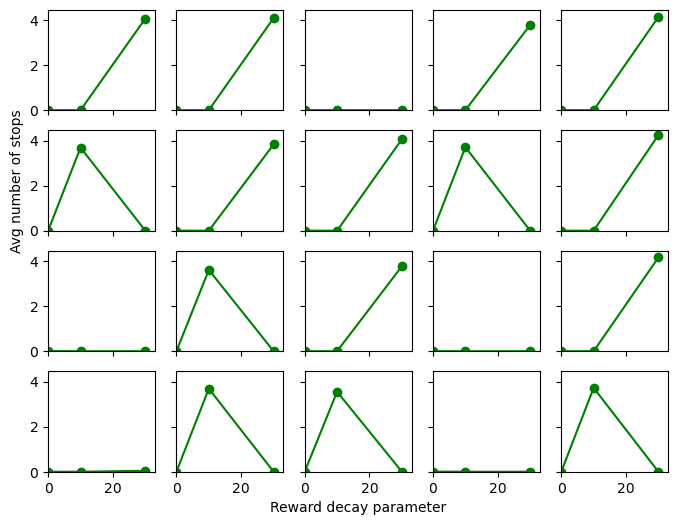

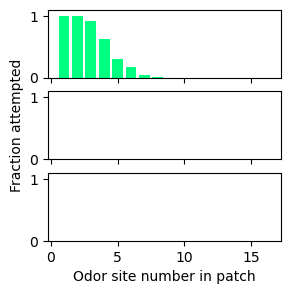

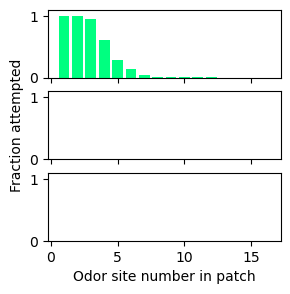

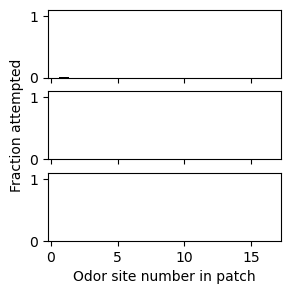

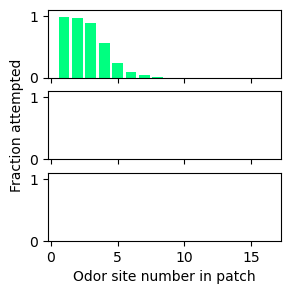

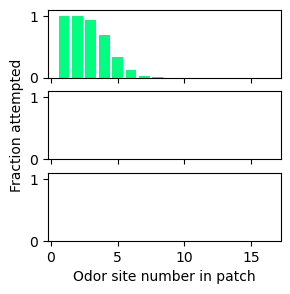

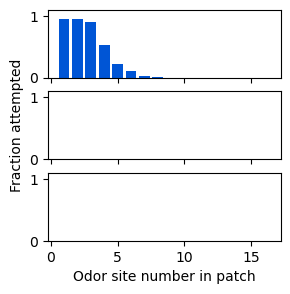

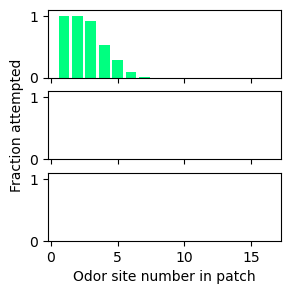

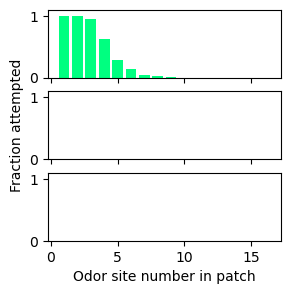

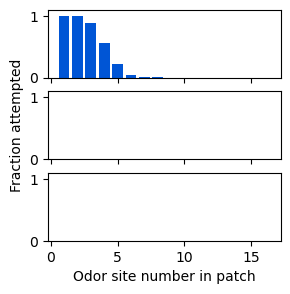

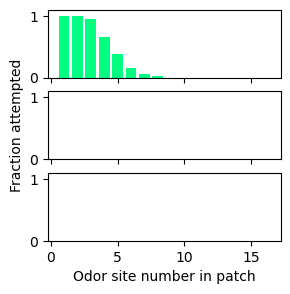

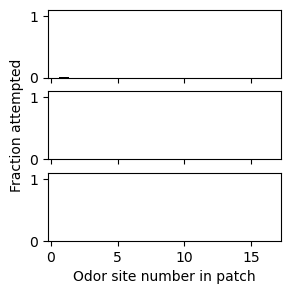

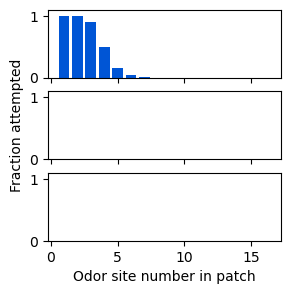

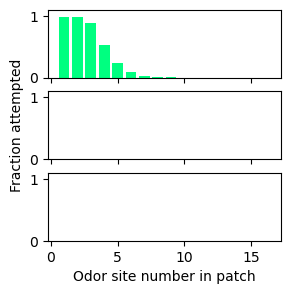

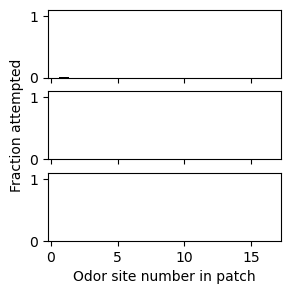

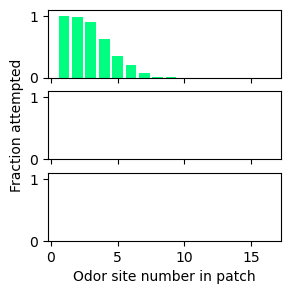

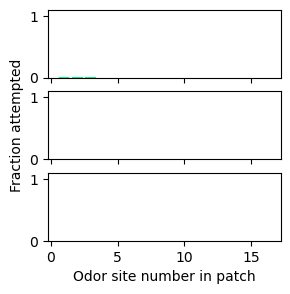

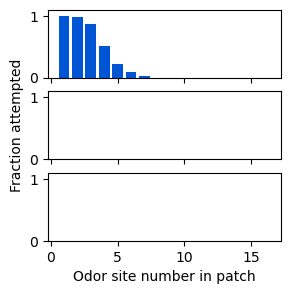

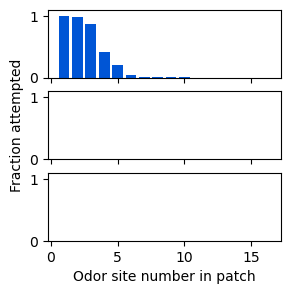

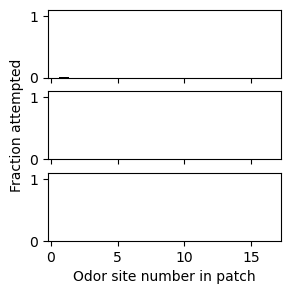

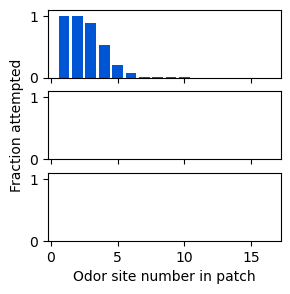

In [69]:
plot_avg_stops_vs_reward_param([
        '../data/rl_agent_outputs/punish_no_reward_200k_2024-10-14_12_07_40_801312_var_noise_0_activity_weight_0/state',
    ],
    max_reward_param=30,
    max_reward_sites=16,          
    model_colors=['green'],
)

['00000.pkl', '00001.pkl', '00002.pkl', '00003.pkl', '00004.pkl', '00005.pkl', '00006.pkl', '00007.pkl']
[17.10715003  8.92214837  0.        ]
[23.  0. 16.]
[24.51329799 11.2754994   0.        ]
[9.35872169 0.         8.25779109]
[19.07984856  0.         26.        ]
[22.69004348 20.          0.        ]
[28.89134995  0.          0.7029537 ]
[16.  0. 20.]
[ 0.         11.          0.85154488]
[ 0.         20.07029364 29.        ]
[0.         8.         0.58561752]
[ 0.         18.50358524  0.        ]
[ 3.41065996 26.33367248  0.        ]
[25.77321854  0.          5.        ]
[25.         18.67532972  0.        ]
[ 0.        13.         0.7013042]
[13.79734216  0.          7.        ]
[ 0.         28.16012534 12.6279909 ]
[18.00481552 21.70891226  0.        ]
[24.83441489  0.          4.01133896]


C:\Users\david.bell\AppData\Local\Temp\ipykernel_4712\3605793695.py:91: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(3, 1, figsize=(3 * scale, 3 * scale), sharex=True, sharey=True)


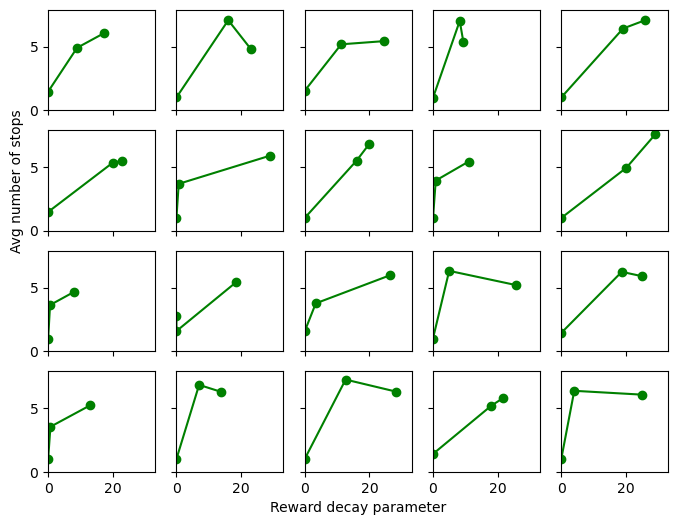

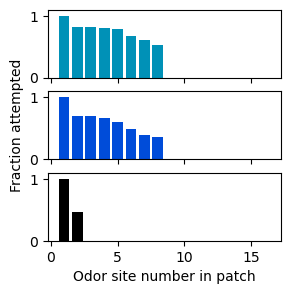

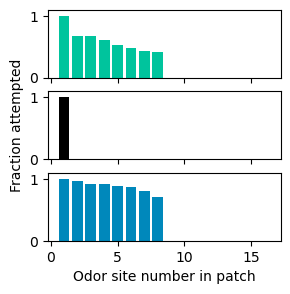

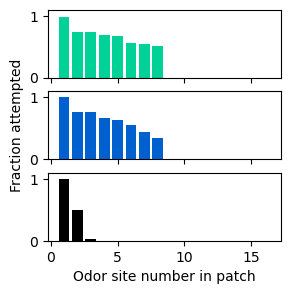

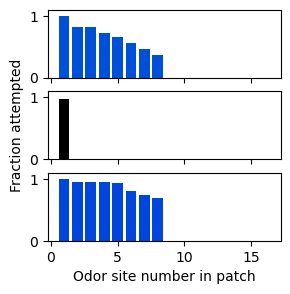

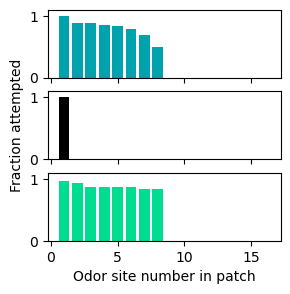

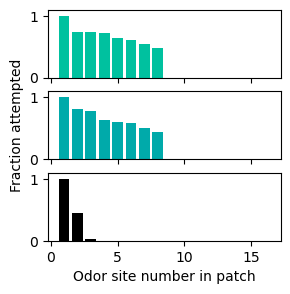

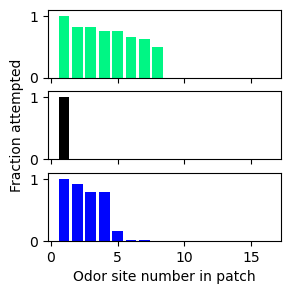

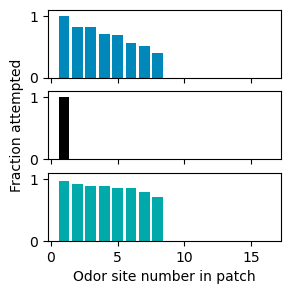

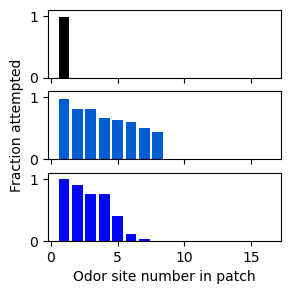

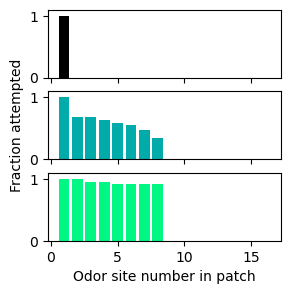

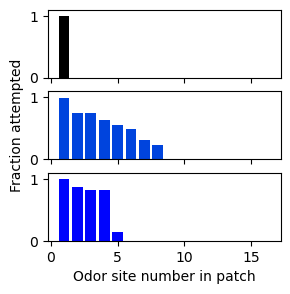

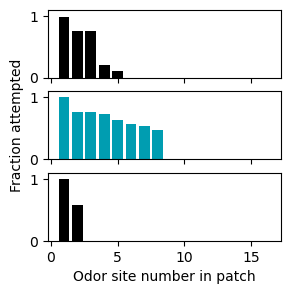

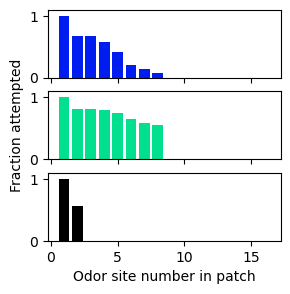

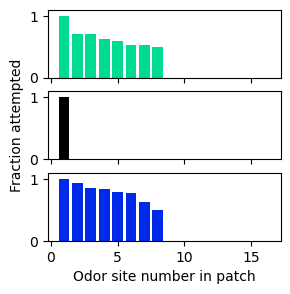

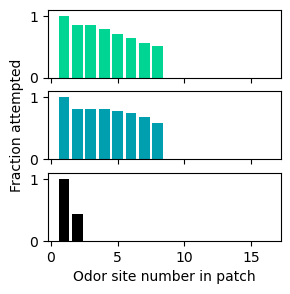

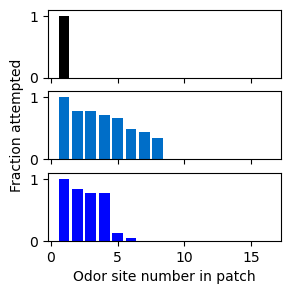

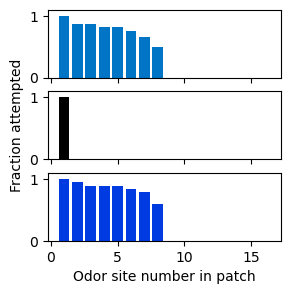

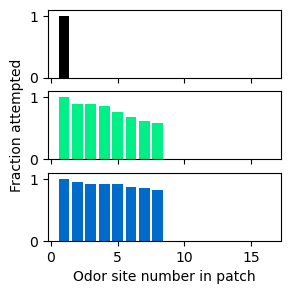

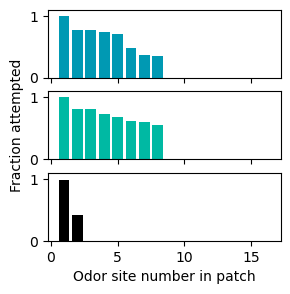

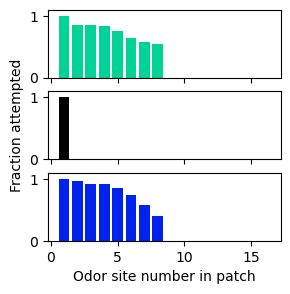

In [71]:
plot_avg_stops_vs_reward_param([
        '../data/rl_agent_outputs/test_one_patch_no_rwd_not_fixed_2024-10-17_08_55_03_222597/state',
    ],
    max_reward_param=30,
    max_reward_sites=16,          
    model_colors=['green'],
)

['00010.pkl', '00020.pkl', '00030.pkl', '00040.pkl', '00050.pkl', '00060.pkl', '00070.pkl', '00080.pkl', '00090.pkl', '00100.pkl', '00110.pkl', '00120.pkl', '00130.pkl', '00140.pkl', '00150.pkl', '00160.pkl', '00170.pkl', '00180.pkl', '00190.pkl', '00200.pkl', '00210.pkl', '00220.pkl', '00230.pkl', '00240.pkl', '00250.pkl', '00260.pkl', '00270.pkl', '00280.pkl', '00290.pkl', '00300.pkl', '00310.pkl', '00320.pkl', '00330.pkl', '00340.pkl', '00350.pkl', '00360.pkl', '00370.pkl', '00380.pkl', '00390.pkl', '00400.pkl', '00410.pkl', '00420.pkl', '00430.pkl', '00440.pkl', '00450.pkl', '00460.pkl', '00470.pkl', '00480.pkl', '00490.pkl', '00500.pkl', '00510.pkl', '00520.pkl', '00530.pkl', '00540.pkl', '00550.pkl', '00560.pkl', '00570.pkl', '00580.pkl', '00590.pkl', '00600.pkl', '00610.pkl', '00620.pkl', '00630.pkl', '00640.pkl', '00650.pkl', '00660.pkl', '00670.pkl', '00680.pkl', '00690.pkl', '00700.pkl', '00710.pkl', '00720.pkl', '00730.pkl', '00740.pkl', '00750.pkl', '00760.pkl', '00770.pkl'

C:\Users\david.bell\AppData\Local\Temp\ipykernel_40588\3605793695.py:91: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(3, 1, figsize=(3 * scale, 3 * scale), sharex=True, sharey=True)


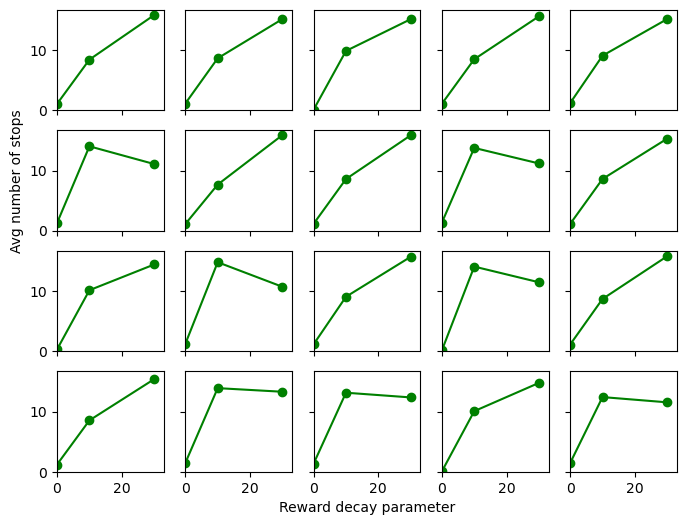

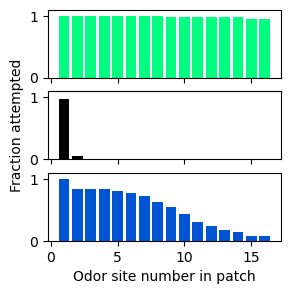

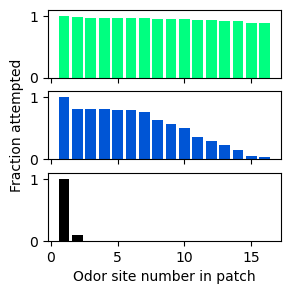

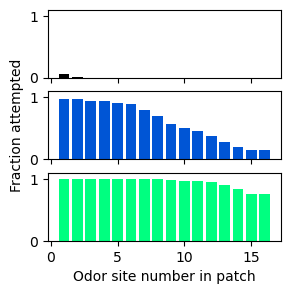

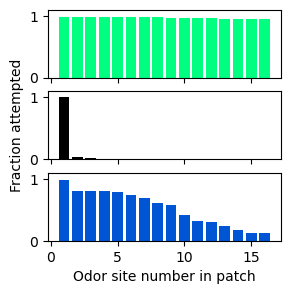

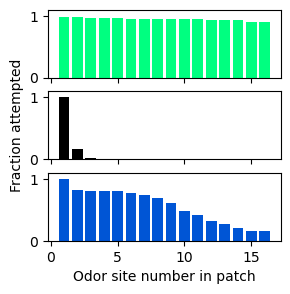

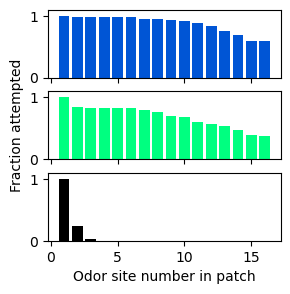

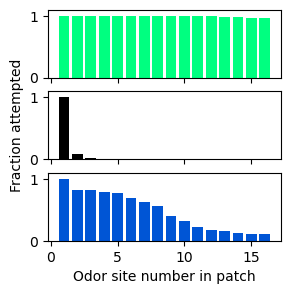

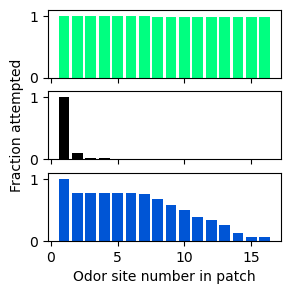

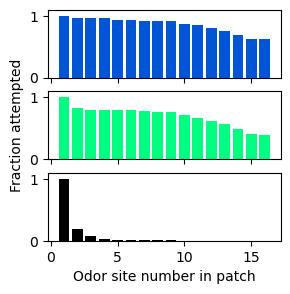

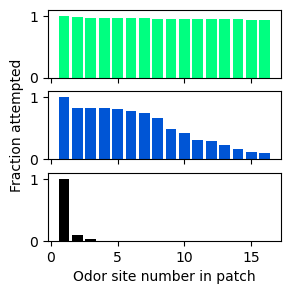

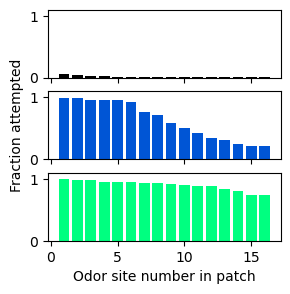

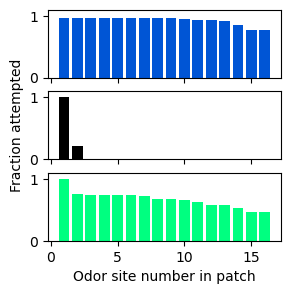

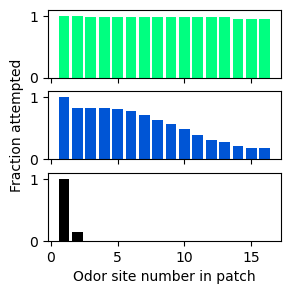

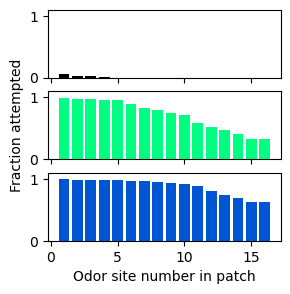

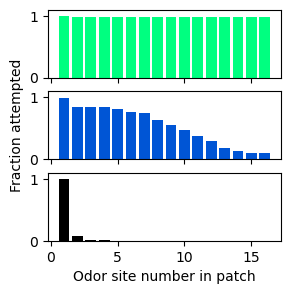

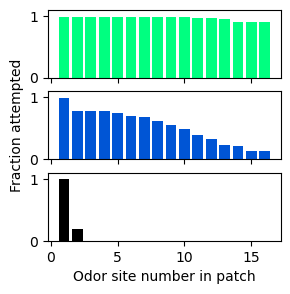

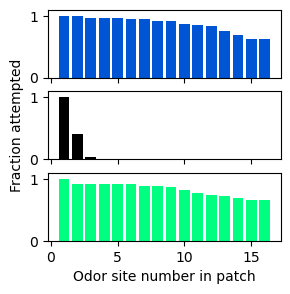

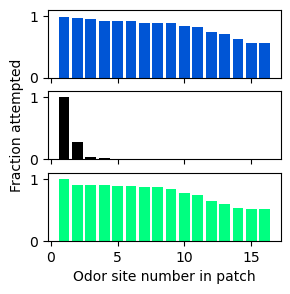

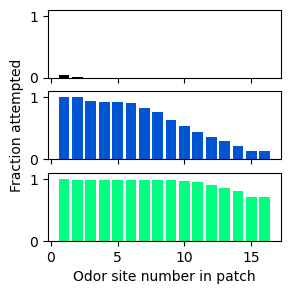

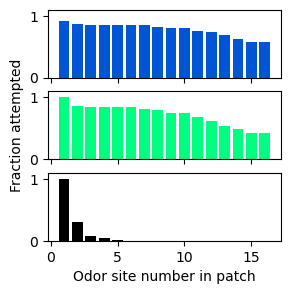

In [36]:
plot_avg_stops_vs_reward_param([
        '../data/rl_agent_outputs/long_sesh_2024-10-26_14_43_26_244595_var_noise_0_activity_weight_0/state',
    ],
    max_reward_param=30,
    max_reward_sites=16,          
    model_colors=['green'],
    update_num=359,
)

['00010.pkl', '00020.pkl', '00030.pkl', '00040.pkl', '00050.pkl', '00060.pkl', '00070.pkl', '00080.pkl', '00090.pkl', '00100.pkl', '00110.pkl', '00120.pkl', '00130.pkl', '00140.pkl', '00150.pkl', '00160.pkl', '00170.pkl', '00180.pkl', '00190.pkl', '00200.pkl', '00210.pkl', '00220.pkl', '00230.pkl', '00240.pkl', '00250.pkl', '00260.pkl', '00270.pkl', '00280.pkl', '00290.pkl', '00300.pkl', '00310.pkl', '00320.pkl', '00330.pkl', '00340.pkl', '00350.pkl', '00360.pkl', '00370.pkl', '00380.pkl', '00390.pkl', '00400.pkl', '00410.pkl', '00420.pkl', '00430.pkl', '00440.pkl', '00450.pkl', '00460.pkl', '00470.pkl', '00480.pkl', '00490.pkl', '00500.pkl', '00510.pkl', '00520.pkl', '00530.pkl', '00540.pkl', '00550.pkl', '00560.pkl', '00570.pkl', '00580.pkl', '00590.pkl', '00600.pkl', '00610.pkl', '00620.pkl', '00630.pkl', '00640.pkl', '00650.pkl', '00660.pkl', '00670.pkl', '00680.pkl', '00690.pkl', '00700.pkl', '00710.pkl', '00720.pkl', '00730.pkl', '00740.pkl', '00750.pkl', '00760.pkl', '00770.pkl'

C:\Users\david.bell\AppData\Local\Temp\ipykernel_36324\3605793695.py:91: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(3, 1, figsize=(3 * scale, 3 * scale), sharex=True, sharey=True)


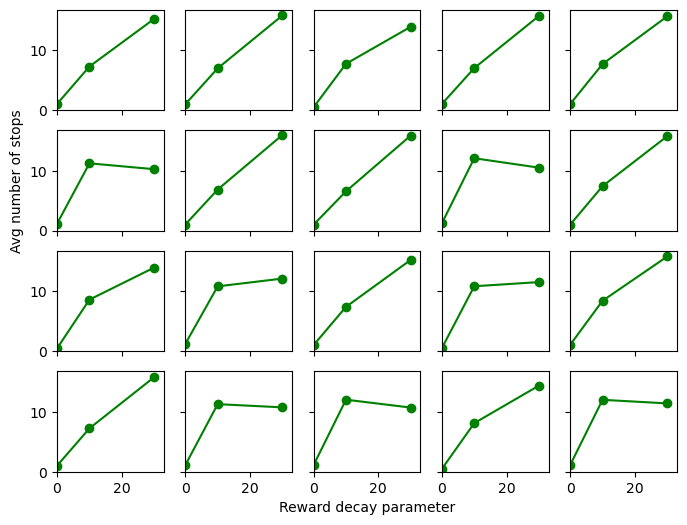

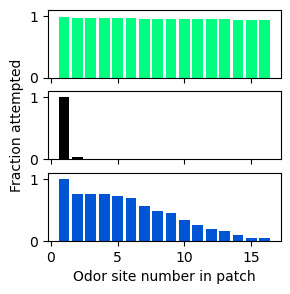

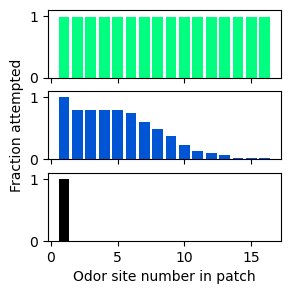

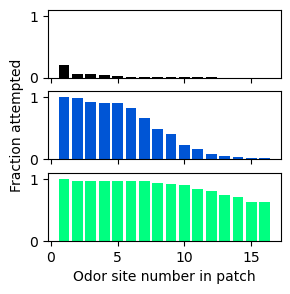

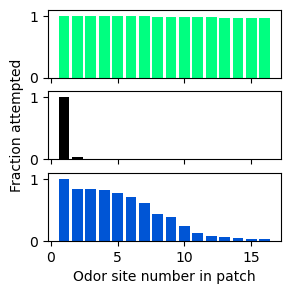

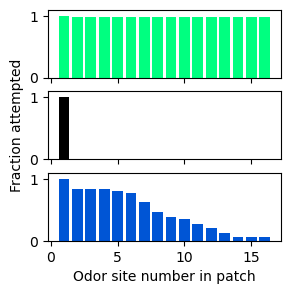

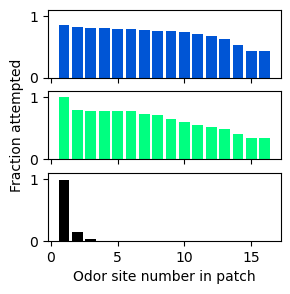

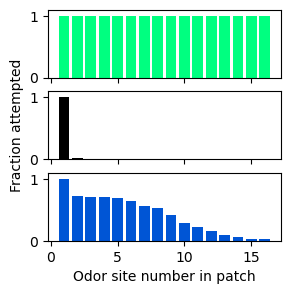

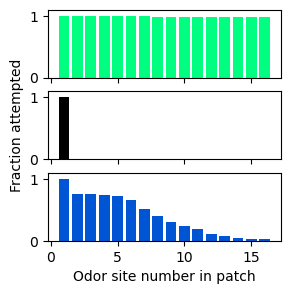

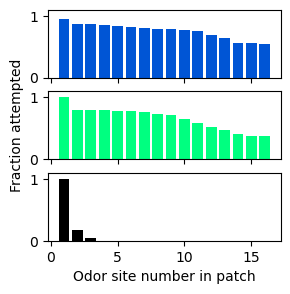

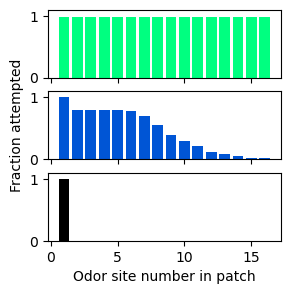

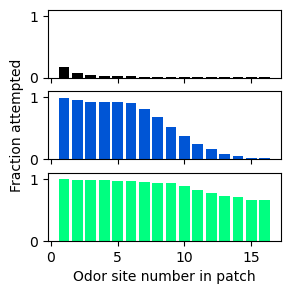

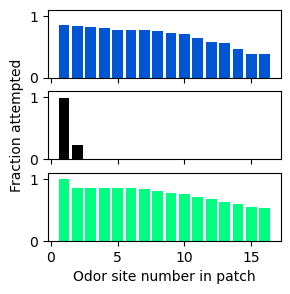

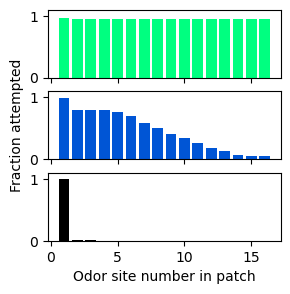

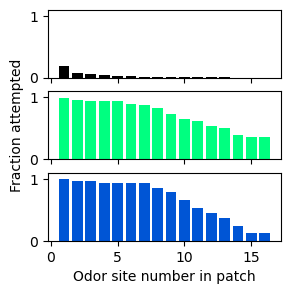

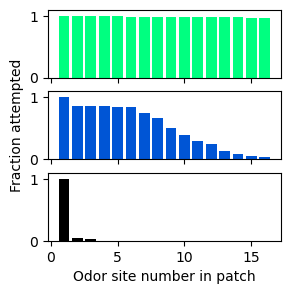

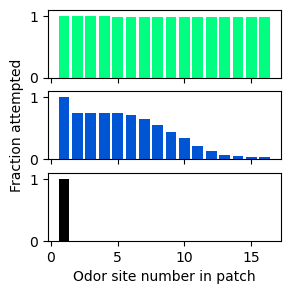

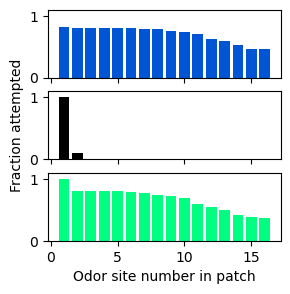

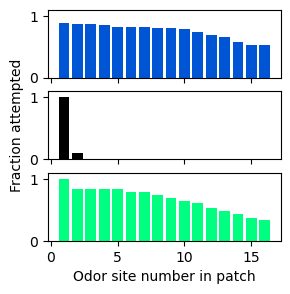

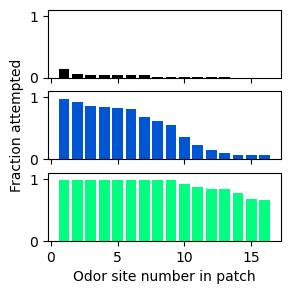

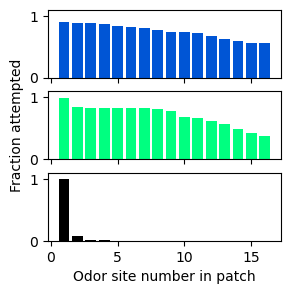

In [8]:
plot_avg_stops_vs_reward_param([
        '../data/rl_agent_outputs/long_sesh_mem_leak_catch_2024-10-29_16_09_59_299165_var_noise_0_activity_weight_0/state',
    ],
    max_reward_param=30,
    max_reward_sites=16,          
    model_colors=['green'],
    update_num=189,
)

['00050.pkl', '00100.pkl', '00150.pkl', '00200.pkl', '00250.pkl', '00300.pkl', '00350.pkl', '00400.pkl', '00450.pkl', '00500.pkl', '00550.pkl', '00600.pkl', '00650.pkl', '00700.pkl', '00750.pkl', '00800.pkl', '00850.pkl', '00900.pkl', '00950.pkl', '01000.pkl', '01050.pkl', '01100.pkl', '01150.pkl', '01200.pkl', '01250.pkl', '01300.pkl', '01350.pkl', '01400.pkl', '01450.pkl', '01500.pkl', '01550.pkl', '01600.pkl', '01650.pkl', '01700.pkl', '01750.pkl', '01800.pkl', '01850.pkl', '01900.pkl', '01950.pkl', '02000.pkl', '02050.pkl', '02100.pkl', '02150.pkl', '02200.pkl', '02250.pkl', '02300.pkl', '02350.pkl', '02400.pkl', '02450.pkl', '02500.pkl', '02550.pkl', '02600.pkl', '02650.pkl', '02700.pkl', '02750.pkl', '02800.pkl', '02850.pkl', '02900.pkl', '02950.pkl', '03000.pkl', '03050.pkl', '03100.pkl', '03150.pkl', '03200.pkl', '03250.pkl', '03300.pkl', '03350.pkl', '03400.pkl', '03450.pkl', '03500.pkl', '03550.pkl', '03600.pkl', '03650.pkl', '03700.pkl', '03750.pkl', '03800.pkl', '03850.pkl'

C:\Users\david.bell\AppData\Local\Temp\ipykernel_9060\3430049099.py:91: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(3, 1, figsize=(3 * scale, 3 * scale), sharex=True, sharey=True)


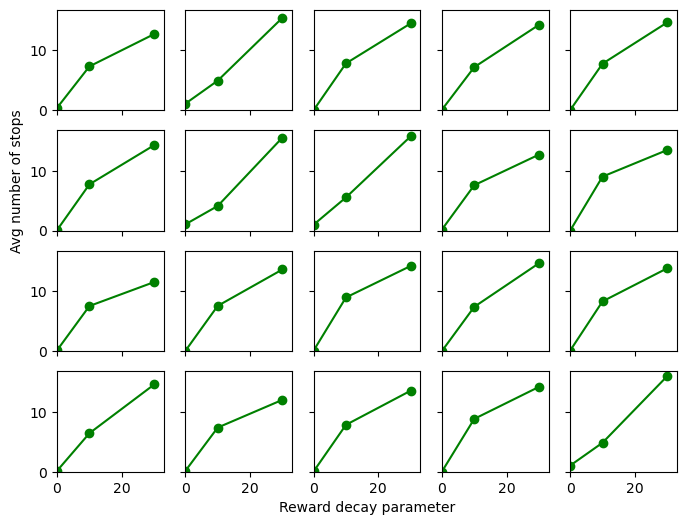

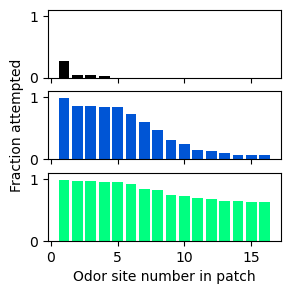

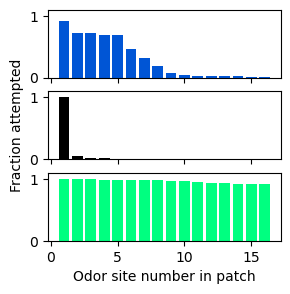

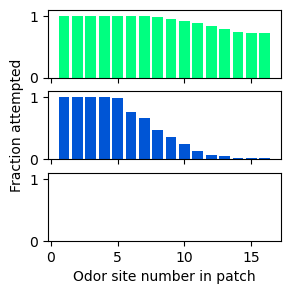

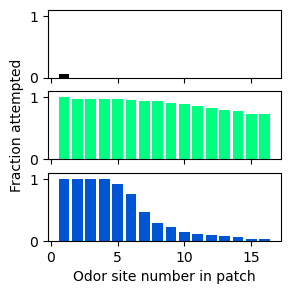

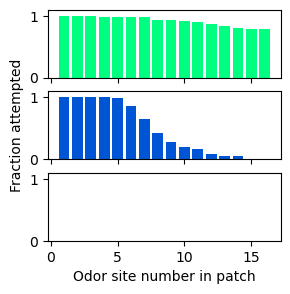

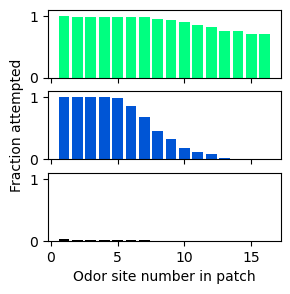

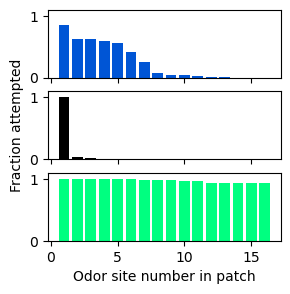

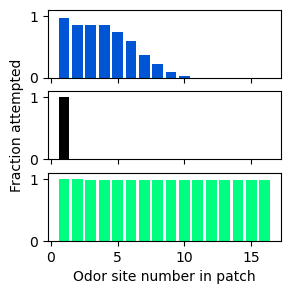

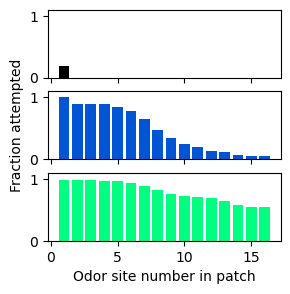

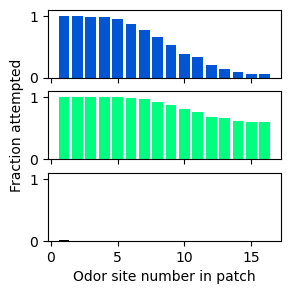

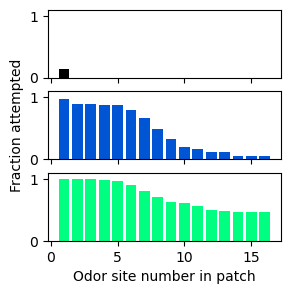

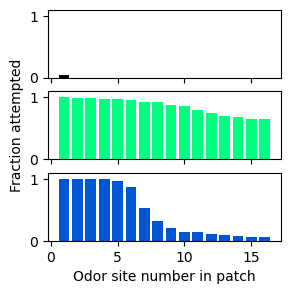

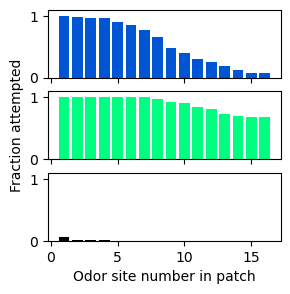

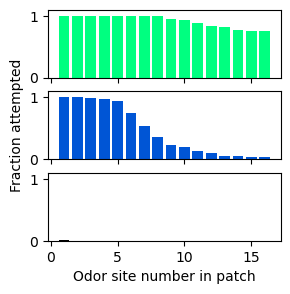

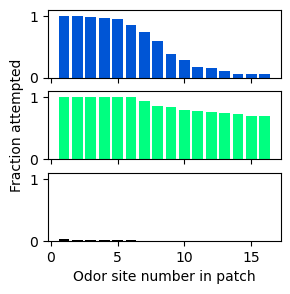

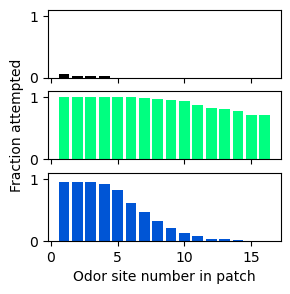

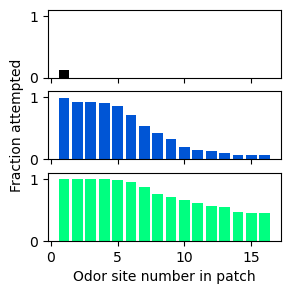

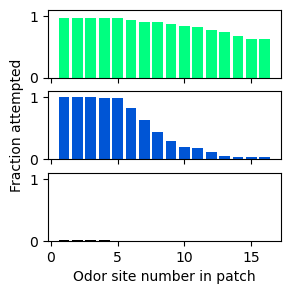

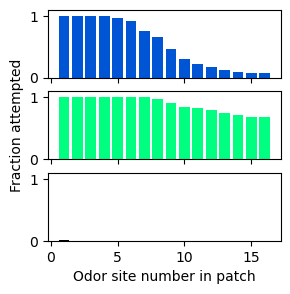

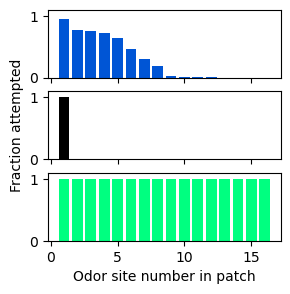

In [7]:
plot_avg_stops_vs_reward_param([
        '../data/rl_agent_outputs/long_sesh_slow_learn_2024-11-08_13_25_37_996089_var_noise_0_activity_weight_0/state',
    ],
    max_reward_param=30,
    max_reward_sites=16,          
    model_colors=['green'],
)

['00050.pkl', '00100.pkl', '00150.pkl', '00200.pkl', '00250.pkl', '00300.pkl', '00350.pkl', '00400.pkl', '00450.pkl', '00500.pkl', '00550.pkl', '00600.pkl', '00650.pkl', '00700.pkl', '00750.pkl', '00800.pkl', '00850.pkl', '00900.pkl', '00950.pkl', '01000.pkl', '01050.pkl', '01100.pkl', '01150.pkl', '01200.pkl', '01250.pkl', '01300.pkl', '01350.pkl', '01400.pkl', '01450.pkl', '01500.pkl', '01550.pkl', '01600.pkl', '01650.pkl', '01700.pkl', '01750.pkl', '01800.pkl', '01850.pkl', '01900.pkl', '01950.pkl', '02000.pkl', '02050.pkl', '02100.pkl', '02150.pkl', '02200.pkl', '02250.pkl', '02300.pkl', '02350.pkl', '02400.pkl', '02450.pkl', '02500.pkl', '02550.pkl', '02600.pkl', '02650.pkl', '02700.pkl', '02750.pkl', '02800.pkl', '02850.pkl', '02900.pkl', '02950.pkl', '03000.pkl', '03050.pkl', '03100.pkl', '03150.pkl', '03200.pkl', '03250.pkl', '03300.pkl', '03350.pkl', '03400.pkl', '03450.pkl', '03500.pkl', '03550.pkl', '03600.pkl', '03650.pkl', '03700.pkl', '03750.pkl', '03800.pkl', '03850.pkl'

C:\Users\david.bell\AppData\Local\Temp\ipykernel_27096\3430049099.py:91: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(3, 1, figsize=(3 * scale, 3 * scale), sharex=True, sharey=True)


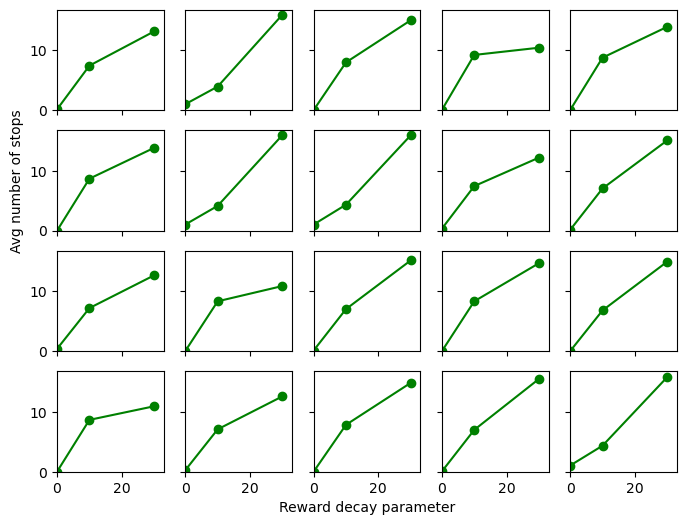

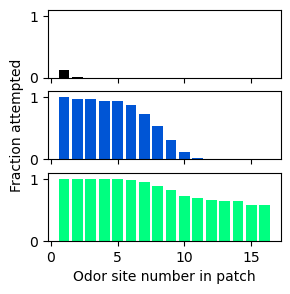

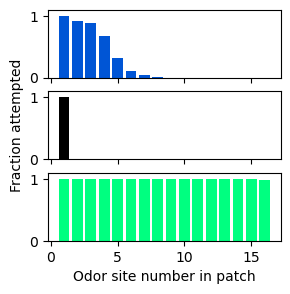

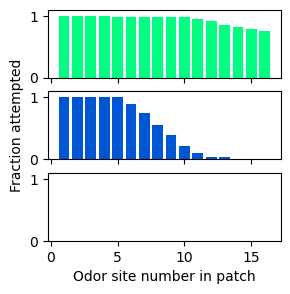

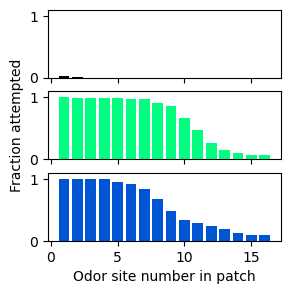

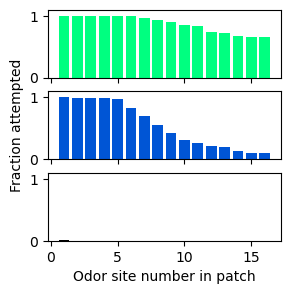

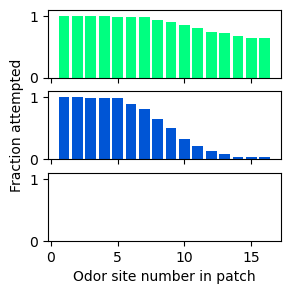

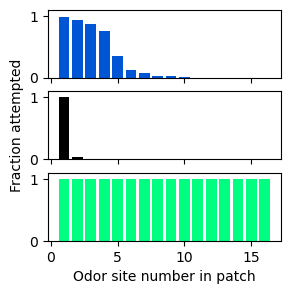

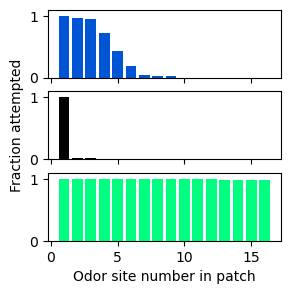

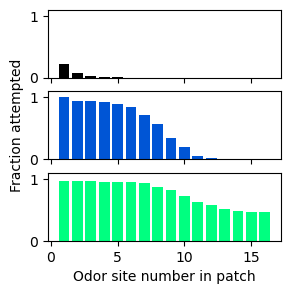

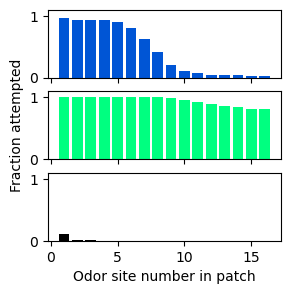

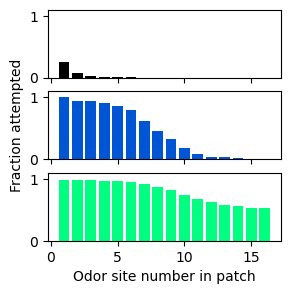

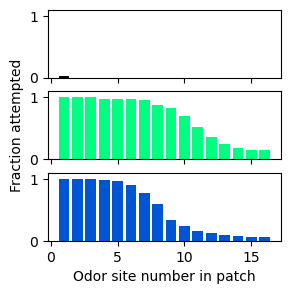

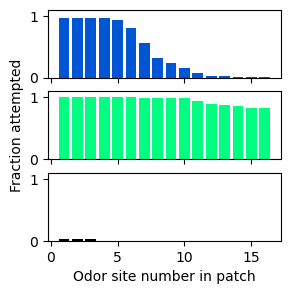

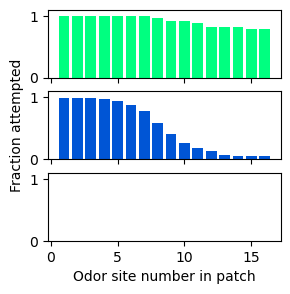

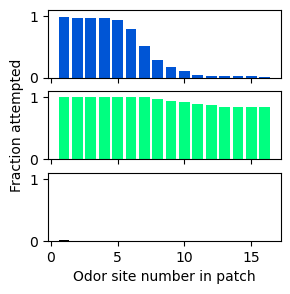

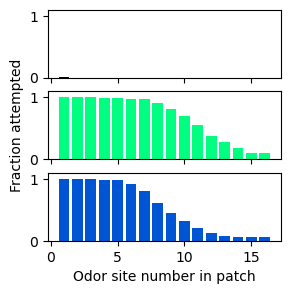

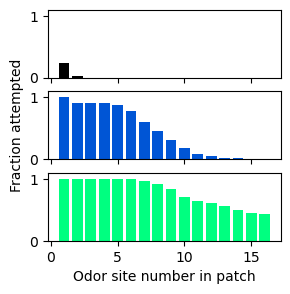

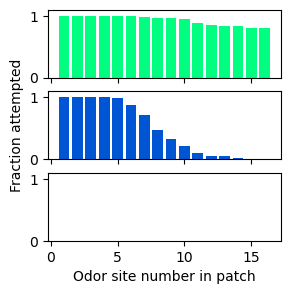

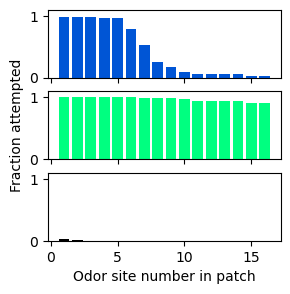

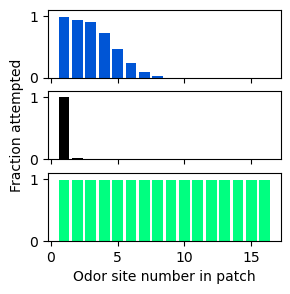

In [12]:
plot_avg_stops_vs_reward_param([
        '../data/rl_agent_outputs/long_sesh_slow_learn_cont_2024-11-15_00_14_55_566253_var_noise_0_activity_weight_0/state',
    ],
    max_reward_param=30,
    max_reward_sites=16,          
    model_colors=['green'],
)

['00001.pkl', '00002.pkl', '00003.pkl', '00004.pkl', '00005.pkl', '00006.pkl', '00007.pkl']
[30. 10.  0.]
[10.  0. 30.]
[ 0. 10. 30.]
[30.  0. 10.]
[10. 30.  0.]
[10.  0. 30.]
[10. 30.  0.]
[30. 10.  0.]
[ 0. 10. 30.]
[10. 30.  0.]
[ 0. 30. 10.]
[ 0. 30. 10.]
[30.  0. 10.]
[ 0. 10. 30.]
[ 0. 30. 10.]
[ 0. 10. 30.]
[ 0. 30. 10.]
[10. 30.  0.]
[10.  0. 30.]
[10.  0. 30.]


C:\Users\david.bell\AppData\Local\Temp\ipykernel_27096\3430049099.py:91: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(3, 1, figsize=(3 * scale, 3 * scale), sharex=True, sharey=True)


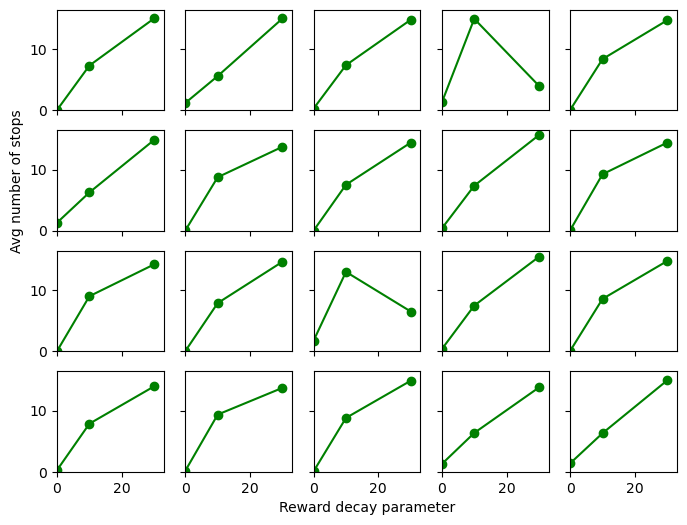

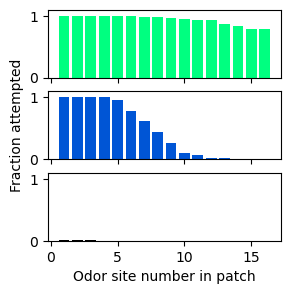

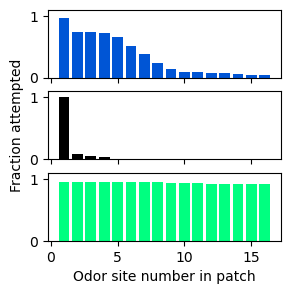

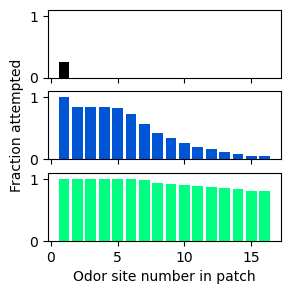

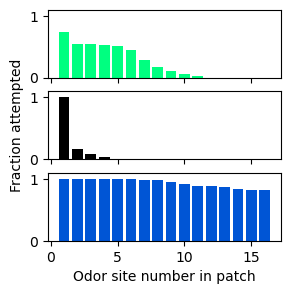

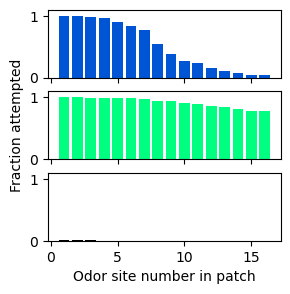

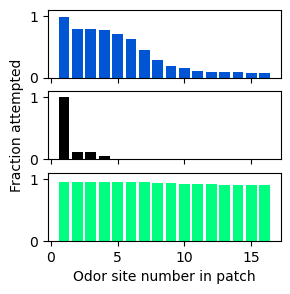

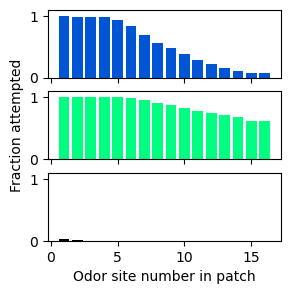

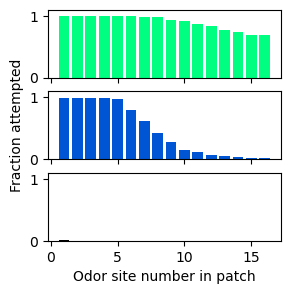

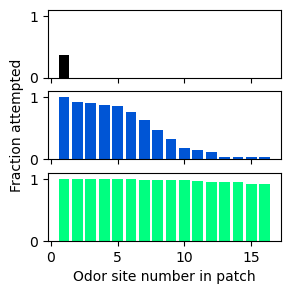

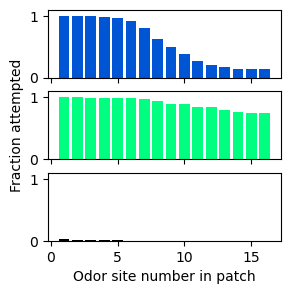

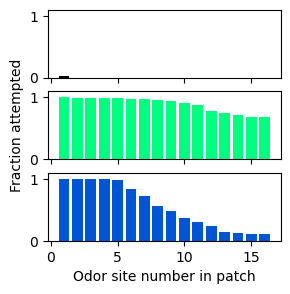

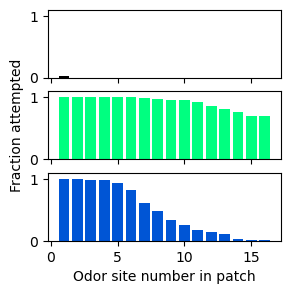

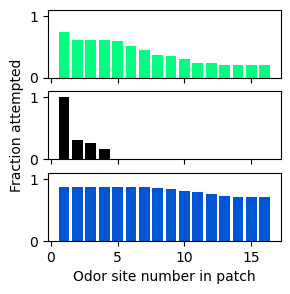

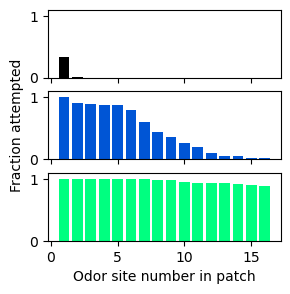

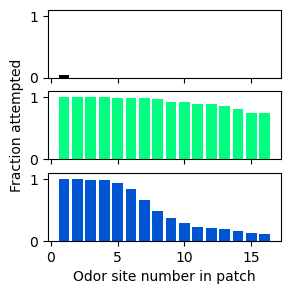

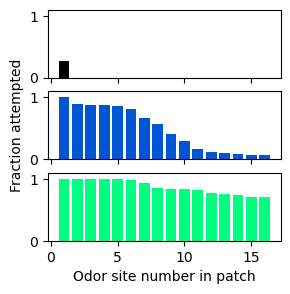

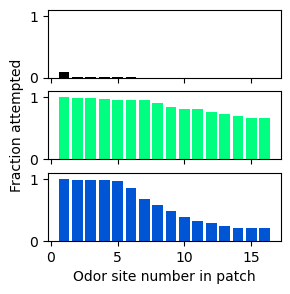

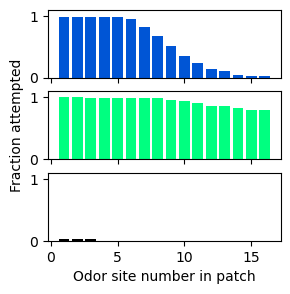

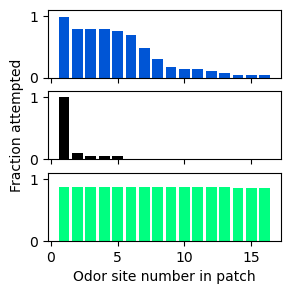

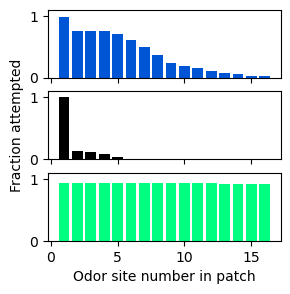

In [9]:
plot_avg_stops_vs_reward_param([
        '../data/rl_agent_outputs/long_sesh_slow_learn_test_2024-11-14_13_52_24_131302_var_noise_0_activity_weight_0/state',
    ],
    max_reward_param=30,
    max_reward_sites=16,          
    model_colors=['green'],
    update_num=0
)